Your patient comes in. They're having a stinging pain in the chest. The X-Ray shows a shadow on the lung. And that shadow is air. If not treated a "collapsed lung"(-ish), or "air on the wrong side of the lung", can result in death.

[What's a Pneumothorax?](https://en.wikipedia.org/wiki/Pneumothorax)

Problem is in an X-Ray, air is usually the thing you ignore. The general idea is:

- Black: Air
- Gray: Fluids and Tissue
- White: Bone and Solids

So the issue is that an air enclosure may just be a mild disturbance in the chest xray. Considering convolutional neural networks are exceptional at identifying abnormalities, we may want them to take a look, as not to miss these tiny abnormalities.


![Futuristic view of human](https://www.publicdomainpictures.net/pictures/50000/nahled/anatomy-high-tech.jpg)

In this challenge, we get chest xrays and masks. In challenges I link below, only bounding boxes were available. Here, we actually get to do dense prediction.

I'm hiding some cells for readability below, just fork the kernel or click the "Show code" on the right to see imports etc. This kernel is just giving some starting info and how to look at the data with the given tools. 

Sources I used and further reading:

- https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
- https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data

Some ideas that might be helpful:

- [Check out Pneumonia X-Ray Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)
- [Use TFRecords](https://www.kaggle.com/lyonzy/convert-dicom-images-to-tfrecords)
- [Check Out Unets](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import glob

import pydicom

#print(os.listdir("../input/siim-acr-pneumothorax-segmentation"))
#print()
#print(os.listdir("../input/siim-acr-pneumothorax-segmentation/sample images"))
# Any results you write to the current directory are saved as output.

from matplotlib import cm
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

import tensorflow as tf

#from tqdm import tqdm_notebook

import sys
#sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## What is DICOM?

Dicom is a format that has metadata, as well as Pixeldata attached to it. Below I extract some basic info with an image. You will know about the gender and age of the patient, as well as info how the image is sampled and generated. Quite useful to programatically read. Here's the [Wikipedia](https://en.wikipedia.org/wiki/DICOM) article for it.

In [2]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Let's first take a look at the sample images that are available. You'll be able to transfer this kernel to downloaded data, to visualize other bits and explore their metadata.

Filename.........: ../data/sample images\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: ['0.168', '0.168']


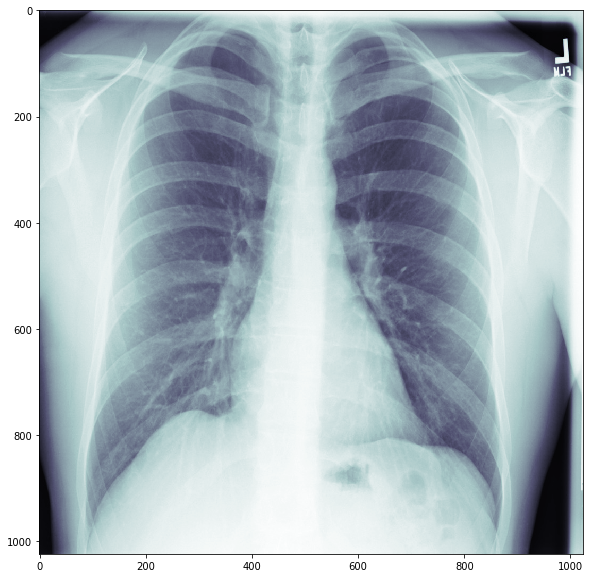

In [3]:
for file_path in glob.glob('../data/sample images/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

## How do the masks look like?

First let's look at all the sample images. We can see different modes of collection. It becomes very evident, that we have to be careful about the top right marker on the image. The different L may mess with our data. Could it be usable leakage as it points to the hospital it was taken at? Yes, yes it could, but I'm *sure* Kaggle took care of this.

Then we'll look at 3 images and the masks that come with it. Personally, I can't really make out how to find the pneumothorax in the images. Play around with it, in some of the other images, it is definitely more visible than in others. Also (thanks to Ehsan) make sure to transpose the masks!

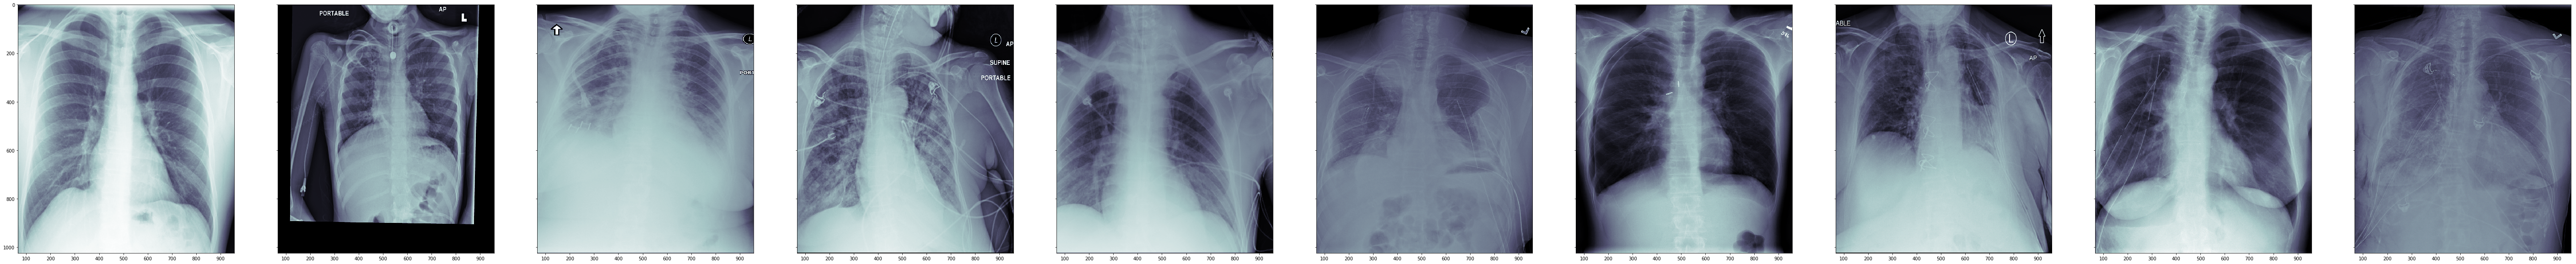

In [4]:
num_img = len(glob.glob('../data/sample images/*.dcm'))
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

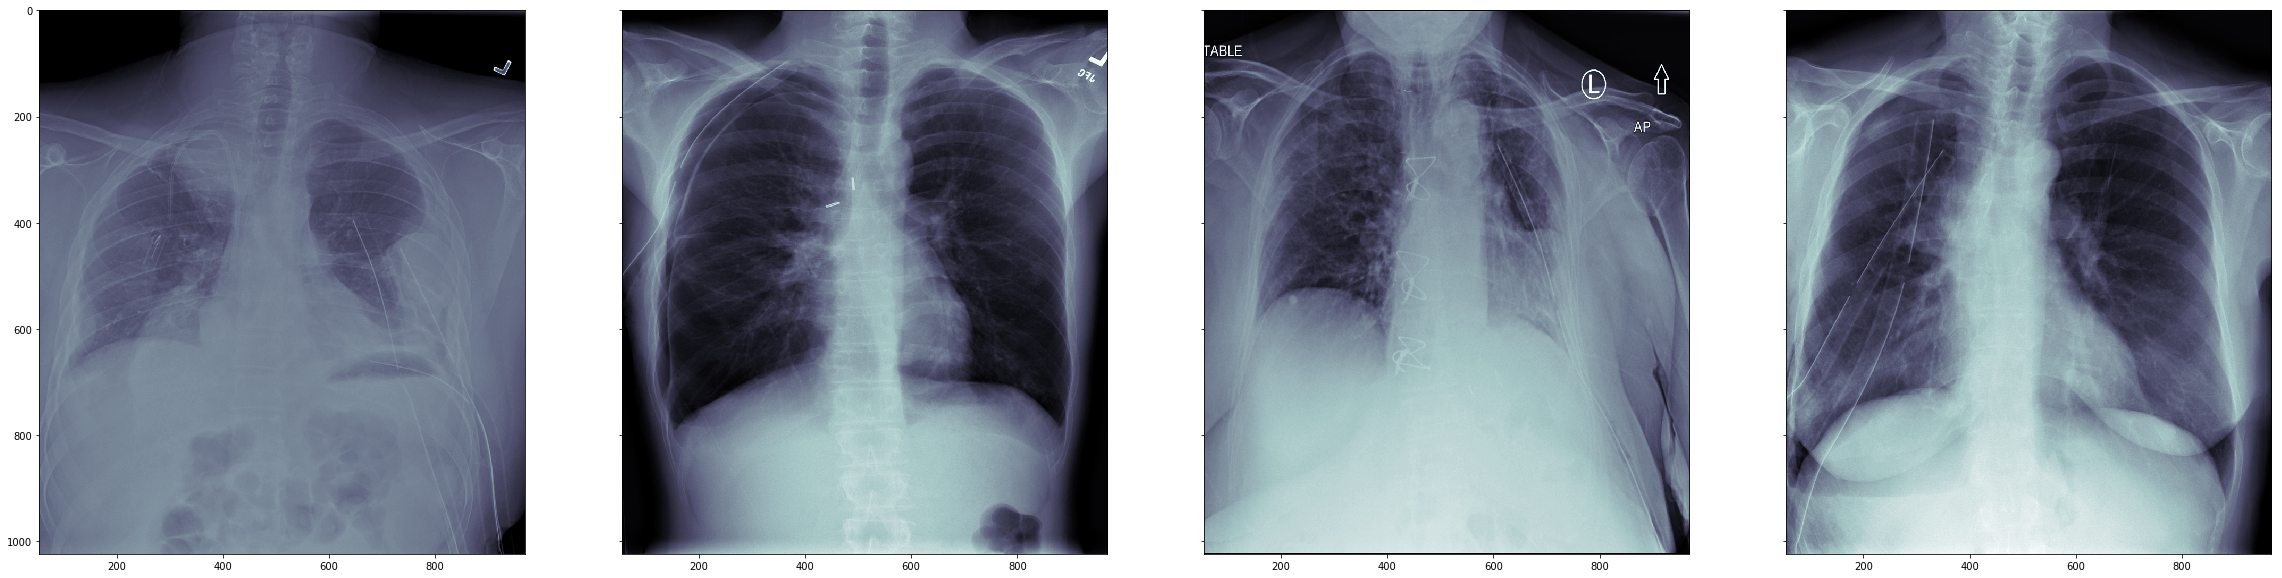

In [5]:
start = 5   # Starting index of images
num_img = 4 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

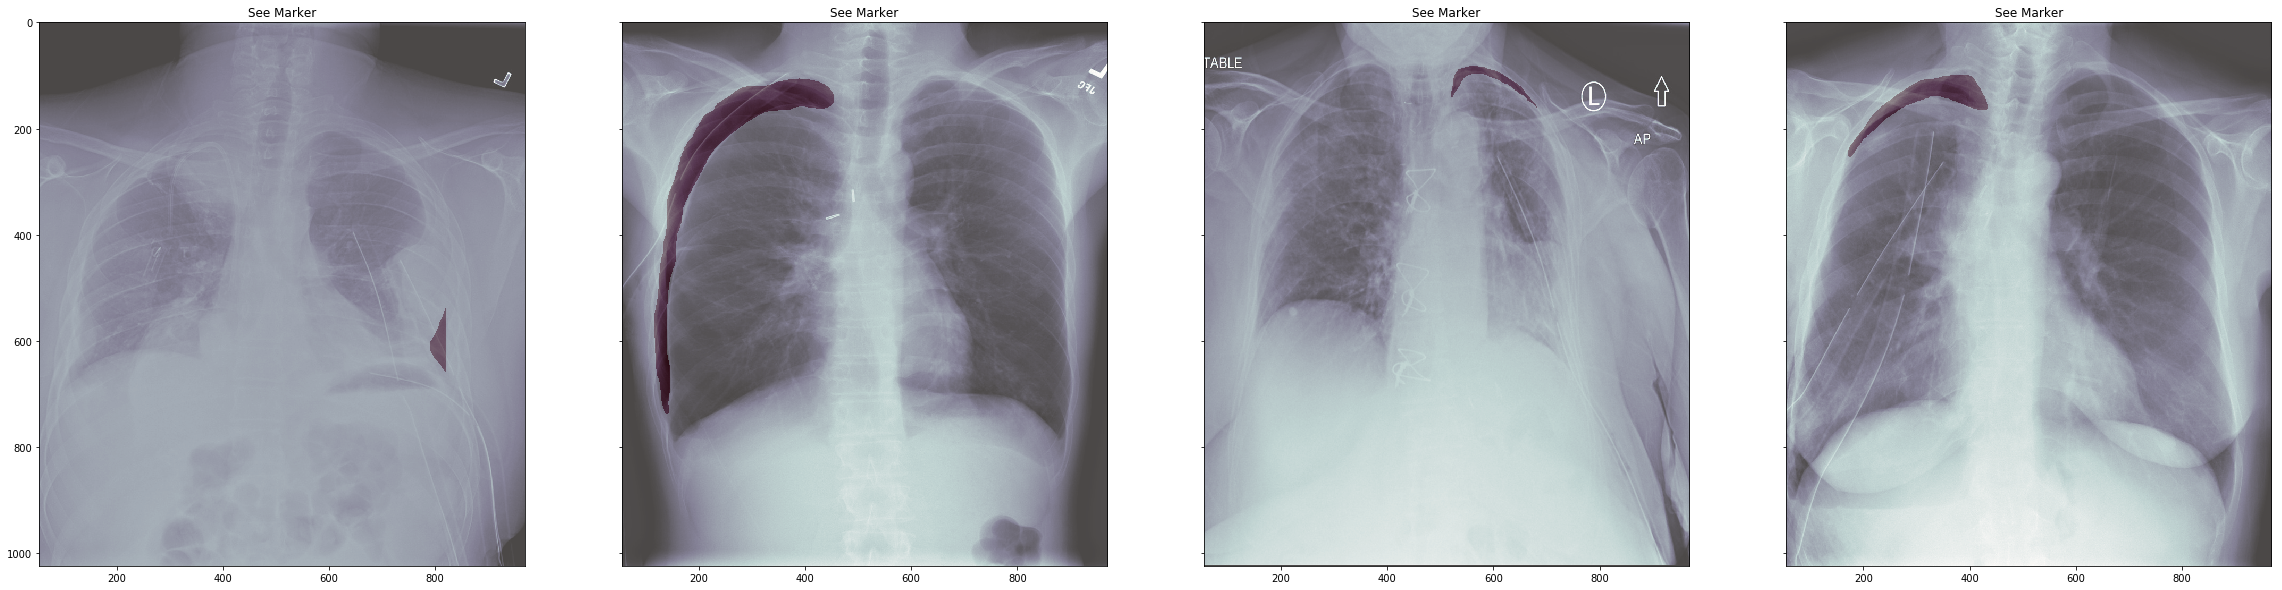

In [6]:
df = pd.read_csv('../data/sample images/train-rle-sample.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('../data/sample images/*.dcm')[start:start+num_img]):
    file_path = file_path.replace('\\', '/')
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')
plt.show()

## Vanilla Unet
So how would we work the data on GCP?

I'd suggest a very nice [Unet](https://arxiv.org/abs/1505.04597), maybe use a pretty pre-trained encoder instead of the following. They're excellent on small-ish datasets and particularly on image segmentation. There are many others you may try, but maybe this one will get you started.

![](http://deeplearning.net/tutorial/_images/unet.jpg)

### Load Full Dataset

In [7]:
train_glob = '../data/dicom-images-train/*/*/*.dcm'
test_glob = '../data/dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))[:5000]
test_fns = sorted(glob.glob(test_glob))[:5000]
df_full = pd.read_csv('../data/train-rle.csv', index_col='ImageId')

In [8]:
df_full.columns

Index([' EncodedPixels'], dtype='object')

This is the point I shake my fist at unstripped strings...

In [9]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
#for n, _id in tqdm_notebook(enumerate(train_fns), total=len(train_fns)):
for n, _id in enumerate(train_fns):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')

Getting train images and masks ... 
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026\1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10000.1517875220.938529\1.2.276.0.7230010.3.1.3.8323329.10000.1517875220.938528\1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10001.1517875220.930579\1.2.276.0.7230010.3.1.3.8323329.10001.1517875220.930578\1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10002.1517875220.939396\1.2.276.0.7230010.3.1.3.8323329.10002.1517875220.939395\1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10031.1517875221.31203\1.2.276.0.7230010.3.1.3.8323329.10031.1517875221.31202\1.2.276.0.7230010.3.1.4.8323329.10031.1517875221.31204 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10032.1517875221.34650\1.2.276.0.7230010.3.1.3.8323329.10032.1517875221.34649\1.2.276.0.7230010.3.1.4.8323329.10032.1517875221.34651 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10033.1517875221.45304\1.2.276.0.7230010.3.1.3.8323329.10033.1517875221.45303\1.2.276.0.7230010.3.1.4.8323329.10033.1517875221.45305 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10034.1517875221.47393\1.2.276.0.7230010.3.1.3.8323329.10034.1517875221.47392\1.2.276.0.7230010.3.1.4.8323329.10034.1517875221.47394 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10035.1517875221.57973\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10073.1517875221.847521\1.2.276.0.7230010.3.1.3.8323329.10073.1517875221.847520\1.2.276.0.7230010.3.1.4.8323329.10073.1517875221.847522 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10074.1517875221.856199\1.2.276.0.7230010.3.1.3.8323329.10074.1517875221.856198\1.2.276.0.7230010.3.1.4.8323329.10074.1517875221.856200 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10075.1517875221.868898\1.2.276.0.7230010.3.1.3.8323329.10075.1517875221.868897\1.2.276.0.7230010.3.1.4.8323329.10075.1517875221.868899 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10076.1517875221.859591\1.2.276.0.7230010.3.1.3.8323329.10076.1517875221.859590\1.2.276.0.7230010.3.1.4.8323329.10076.1517875221.859592 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10077.1517875221.8688

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10106.1517875222.107966\1.2.276.0.7230010.3.1.3.8323329.10106.1517875222.107965\1.2.276.0.7230010.3.1.4.8323329.10106.1517875222.107967 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10107.1517875222.121329\1.2.276.0.7230010.3.1.3.8323329.10107.1517875222.121328\1.2.276.0.7230010.3.1.4.8323329.10107.1517875222.121330 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10108.1517875222.137480\1.2.276.0.7230010.3.1.3.8323329.10108.1517875222.137479\1.2.276.0.7230010.3.1.4.8323329.10108.1517875222.137481 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10109.1517875222.147174\1.2.276.0.7230010.3.1.3.8323329.10109.1517875222.147173\1.2.276.0.7230010.3.1.4.8323329.10109.1517875222.147175 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1011.1517875165.90497

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10145.1517875222.327604\1.2.276.0.7230010.3.1.3.8323329.10145.1517875222.327603\1.2.276.0.7230010.3.1.4.8323329.10145.1517875222.327605 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10146.1517875222.331901\1.2.276.0.7230010.3.1.3.8323329.10146.1517875222.331900\1.2.276.0.7230010.3.1.4.8323329.10146.1517875222.331902 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10147.1517875222.345668\1.2.276.0.7230010.3.1.3.8323329.10147.1517875222.345667\1.2.276.0.7230010.3.1.4.8323329.10147.1517875222.345669 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10148.1517875222.344314\1.2.276.0.7230010.3.1.3.8323329.10148.1517875222.344313\1.2.276.0.7230010.3.1.4.8323329.10148.1517875222.344315 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10149.1517875222.3597

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10181.1517875222.501594\1.2.276.0.7230010.3.1.3.8323329.10181.1517875222.501593\1.2.276.0.7230010.3.1.4.8323329.10181.1517875222.501595 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10182.1517875222.500152\1.2.276.0.7230010.3.1.3.8323329.10182.1517875222.500151\1.2.276.0.7230010.3.1.4.8323329.10182.1517875222.500153 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10183.1517875222.515642\1.2.276.0.7230010.3.1.3.8323329.10183.1517875222.515641\1.2.276.0.7230010.3.1.4.8323329.10183.1517875222.515643 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10184.1517875222.519435\1.2.276.0.7230010.3.1.3.8323329.10184.1517875222.519434\1.2.276.0.7230010.3.1.4.8323329.10184.1517875222.519436 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10185.1517875222.5234

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10218.1517875222.667654\1.2.276.0.7230010.3.1.3.8323329.10218.1517875222.667653\1.2.276.0.7230010.3.1.4.8323329.10218.1517875222.667655 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10219.1517875222.667088\1.2.276.0.7230010.3.1.3.8323329.10219.1517875222.667087\1.2.276.0.7230010.3.1.4.8323329.10219.1517875222.667089 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1022.1517875165.946422\1.2.276.0.7230010.3.1.3.8323329.1022.1517875165.946421\1.2.276.0.7230010.3.1.4.8323329.1022.1517875165.946423 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10220.1517875222.665545\1.2.276.0.7230010.3.1.3.8323329.10220.1517875222.665544\1.2.276.0.7230010.3.1.4.8323329.10220.1517875222.665546 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10221.1517875222.683782\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10255.1517875222.866457\1.2.276.0.7230010.3.1.3.8323329.10255.1517875222.866456\1.2.276.0.7230010.3.1.4.8323329.10255.1517875222.866458 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10256.1517875222.861704\1.2.276.0.7230010.3.1.3.8323329.10256.1517875222.861703\1.2.276.0.7230010.3.1.4.8323329.10256.1517875222.861705 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10257.1517875222.866509\1.2.276.0.7230010.3.1.3.8323329.10257.1517875222.866508\1.2.276.0.7230010.3.1.4.8323329.10257.1517875222.866510 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10258.1517875222.884066\1.2.276.0.7230010.3.1.3.8323329.10258.1517875222.884065\1.2.276.0.7230010.3.1.4.8323329.10258.1517875222.884067 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10259.1517875222.8746

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10291.1517875222.993824\1.2.276.0.7230010.3.1.3.8323329.10291.1517875222.993823\1.2.276.0.7230010.3.1.4.8323329.10291.1517875222.993825 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10292.1517875222.808\1.2.276.0.7230010.3.1.3.8323329.10292.1517875222.807\1.2.276.0.7230010.3.1.4.8323329.10292.1517875222.809 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10293.1517875223.11306\1.2.276.0.7230010.3.1.3.8323329.10293.1517875223.11305\1.2.276.0.7230010.3.1.4.8323329.10293.1517875223.11307 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10294.1517875223.21646\1.2.276.0.7230010.3.1.3.8323329.10294.1517875223.21645\1.2.276.0.7230010.3.1.4.8323329.10294.1517875223.21647 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10295.1517875223.23165\1.2.276.0.723

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10324.1517875223.149083\1.2.276.0.7230010.3.1.3.8323329.10324.1517875223.149082\1.2.276.0.7230010.3.1.4.8323329.10324.1517875223.149084 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10325.1517875223.158904\1.2.276.0.7230010.3.1.3.8323329.10325.1517875223.158903\1.2.276.0.7230010.3.1.4.8323329.10325.1517875223.158905 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10326.1517875223.162364\1.2.276.0.7230010.3.1.3.8323329.10326.1517875223.162363\1.2.276.0.7230010.3.1.4.8323329.10326.1517875223.162365 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10327.1517875223.167354\1.2.276.0.7230010.3.1.3.8323329.10327.1517875223.167353\1.2.276.0.7230010.3.1.4.8323329.10327.1517875223.167355 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10328.1517875223.1778

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10358.1517875223.346263\1.2.276.0.7230010.3.1.3.8323329.10358.1517875223.346262\1.2.276.0.7230010.3.1.4.8323329.10358.1517875223.346264 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10359.1517875223.342951\1.2.276.0.7230010.3.1.3.8323329.10359.1517875223.342950\1.2.276.0.7230010.3.1.4.8323329.10359.1517875223.342952 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1036.1517875166.13054\1.2.276.0.7230010.3.1.3.8323329.1036.1517875166.13053\1.2.276.0.7230010.3.1.4.8323329.1036.1517875166.13055 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10360.1517875223.345201\1.2.276.0.7230010.3.1.3.8323329.10360.1517875223.345200\1.2.276.0.7230010.3.1.4.8323329.10360.1517875223.345202 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10361.1517875223.364491\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10393.1517875223.501772\1.2.276.0.7230010.3.1.3.8323329.10393.1517875223.501771\1.2.276.0.7230010.3.1.4.8323329.10393.1517875223.501773 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10394.1517875223.514391\1.2.276.0.7230010.3.1.3.8323329.10394.1517875223.514390\1.2.276.0.7230010.3.1.4.8323329.10394.1517875223.514392 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10395.1517875223.513439\1.2.276.0.7230010.3.1.3.8323329.10395.1517875223.513438\1.2.276.0.7230010.3.1.4.8323329.10395.1517875223.513440 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10396.1517875223.523721\1.2.276.0.7230010.3.1.3.8323329.10396.1517875223.523720\1.2.276.0.7230010.3.1.4.8323329.10396.1517875223.523722 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10397.1517875223.5217

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10428.1517875223.681254\1.2.276.0.7230010.3.1.3.8323329.10428.1517875223.681253\1.2.276.0.7230010.3.1.4.8323329.10428.1517875223.681255 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10429.1517875223.681533\1.2.276.0.7230010.3.1.3.8323329.10429.1517875223.681532\1.2.276.0.7230010.3.1.4.8323329.10429.1517875223.681534 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10430.1517875223.687045\1.2.276.0.7230010.3.1.3.8323329.10430.1517875223.687044\1.2.276.0.7230010.3.1.4.8323329.10430.1517875223.687046 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10431.1517875223.701522\1.2.276.0.7230010.3.1.3.8323329.10431.1517875223.701521\1.2.276.0.7230010.3.1.4.8323329.10431.1517875223.701523 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10432.1517875223.6966

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10462.1517875223.816148\1.2.276.0.7230010.3.1.3.8323329.10462.1517875223.816147\1.2.276.0.7230010.3.1.4.8323329.10462.1517875223.816149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10463.1517875223.817303\1.2.276.0.7230010.3.1.3.8323329.10463.1517875223.817302\1.2.276.0.7230010.3.1.4.8323329.10463.1517875223.817304 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10464.1517875223.829668\1.2.276.0.7230010.3.1.3.8323329.10464.1517875223.829667\1.2.276.0.7230010.3.1.4.8323329.10464.1517875223.829669 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10465.1517875223.832301\1.2.276.0.7230010.3.1.3.8323329.10465.1517875223.832300\1.2.276.0.7230010.3.1.4.8323329.10465.1517875223.832302 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10466.1517875223.8303

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10496.1517875223.953094\1.2.276.0.7230010.3.1.3.8323329.10496.1517875223.953093\1.2.276.0.7230010.3.1.4.8323329.10496.1517875223.953095 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10497.1517875223.957580\1.2.276.0.7230010.3.1.3.8323329.10497.1517875223.957579\1.2.276.0.7230010.3.1.4.8323329.10497.1517875223.957581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10498.1517875223.970401\1.2.276.0.7230010.3.1.3.8323329.10498.1517875223.970400\1.2.276.0.7230010.3.1.4.8323329.10498.1517875223.970402 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10499.1517875223.984222\1.2.276.0.7230010.3.1.3.8323329.10499.1517875223.984221\1.2.276.0.7230010.3.1.4.8323329.10499.1517875223.984223 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1050.1517875166.61981

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10529.1517875224.145904\1.2.276.0.7230010.3.1.3.8323329.10529.1517875224.145903\1.2.276.0.7230010.3.1.4.8323329.10529.1517875224.145905 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1053.1517875166.78059\1.2.276.0.7230010.3.1.3.8323329.1053.1517875166.78058\1.2.276.0.7230010.3.1.4.8323329.1053.1517875166.78060 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10530.1517875224.151247\1.2.276.0.7230010.3.1.3.8323329.10530.1517875224.151246\1.2.276.0.7230010.3.1.4.8323329.10530.1517875224.151248 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10531.1517875224.152337\1.2.276.0.7230010.3.1.3.8323329.10531.1517875224.152336\1.2.276.0.7230010.3.1.4.8323329.10531.1517875224.152338 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10532.1517875224.159381\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10566.1517875224.308116\1.2.276.0.7230010.3.1.3.8323329.10566.1517875224.308115\1.2.276.0.7230010.3.1.4.8323329.10566.1517875224.308117 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10567.1517875224.320688\1.2.276.0.7230010.3.1.3.8323329.10567.1517875224.320687\1.2.276.0.7230010.3.1.4.8323329.10567.1517875224.320689 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10568.1517875224.312783\1.2.276.0.7230010.3.1.3.8323329.10568.1517875224.312782\1.2.276.0.7230010.3.1.4.8323329.10568.1517875224.312784 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10569.1517875224.312446\1.2.276.0.7230010.3.1.3.8323329.10569.1517875224.312445\1.2.276.0.7230010.3.1.4.8323329.10569.1517875224.312447 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1057.1517875166.87691

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10605.1517875224.512765\1.2.276.0.7230010.3.1.3.8323329.10605.1517875224.512764\1.2.276.0.7230010.3.1.4.8323329.10605.1517875224.512766 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10606.1517875224.513436\1.2.276.0.7230010.3.1.3.8323329.10606.1517875224.513435\1.2.276.0.7230010.3.1.4.8323329.10606.1517875224.513437 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10607.1517875224.529204\1.2.276.0.7230010.3.1.3.8323329.10607.1517875224.529203\1.2.276.0.7230010.3.1.4.8323329.10607.1517875224.529205 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10608.1517875224.535200\1.2.276.0.7230010.3.1.3.8323329.10608.1517875224.535199\1.2.276.0.7230010.3.1.4.8323329.10608.1517875224.535201 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10609.1517875224.5310

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10638.1517875224.671319\1.2.276.0.7230010.3.1.3.8323329.10638.1517875224.671318\1.2.276.0.7230010.3.1.4.8323329.10638.1517875224.671320 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10639.1517875224.676251\1.2.276.0.7230010.3.1.3.8323329.10639.1517875224.676250\1.2.276.0.7230010.3.1.4.8323329.10639.1517875224.676252 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1064.1517875166.120136\1.2.276.0.7230010.3.1.3.8323329.1064.1517875166.120135\1.2.276.0.7230010.3.1.4.8323329.1064.1517875166.120137 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10640.1517875224.676816\1.2.276.0.7230010.3.1.3.8323329.10640.1517875224.676815\1.2.276.0.7230010.3.1.4.8323329.10640.1517875224.676817 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10641.1517875224.691759\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10673.1517875224.2650\1.2.276.0.7230010.3.1.3.8323329.10673.1517875224.2649\1.2.276.0.7230010.3.1.4.8323329.10673.1517875224.2651 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10674.1517875224.997552\1.2.276.0.7230010.3.1.3.8323329.10674.1517875224.997551\1.2.276.0.7230010.3.1.4.8323329.10674.1517875224.997553 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10675.1517875225.3609\1.2.276.0.7230010.3.1.3.8323329.10675.1517875225.3608\1.2.276.0.7230010.3.1.4.8323329.10675.1517875225.3610 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10676.1517875225.27815\1.2.276.0.7230010.3.1.3.8323329.10676.1517875225.27814\1.2.276.0.7230010.3.1.4.8323329.10676.1517875225.27816 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10677.1517875225.29878\1.2.276.0.723

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10712.1517875225.224679\1.2.276.0.7230010.3.1.3.8323329.10712.1517875225.224678\1.2.276.0.7230010.3.1.4.8323329.10712.1517875225.224680 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10713.1517875225.217664\1.2.276.0.7230010.3.1.3.8323329.10713.1517875225.217663\1.2.276.0.7230010.3.1.4.8323329.10713.1517875225.217665 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10714.1517875225.228563\1.2.276.0.7230010.3.1.3.8323329.10714.1517875225.228562\1.2.276.0.7230010.3.1.4.8323329.10714.1517875225.228564 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10715.1517875225.231768\1.2.276.0.7230010.3.1.3.8323329.10715.1517875225.231767\1.2.276.0.7230010.3.1.4.8323329.10715.1517875225.231769 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10716.1517875225.2441

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10745.1517875225.421269\1.2.276.0.7230010.3.1.3.8323329.10745.1517875225.421268\1.2.276.0.7230010.3.1.4.8323329.10745.1517875225.421270 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10746.1517875225.439930\1.2.276.0.7230010.3.1.3.8323329.10746.1517875225.439929\1.2.276.0.7230010.3.1.4.8323329.10746.1517875225.439931 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10747.1517875225.441275\1.2.276.0.7230010.3.1.3.8323329.10747.1517875225.441274\1.2.276.0.7230010.3.1.4.8323329.10747.1517875225.441276 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10748.1517875225.442853\1.2.276.0.7230010.3.1.3.8323329.10748.1517875225.442852\1.2.276.0.7230010.3.1.4.8323329.10748.1517875225.442854 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10749.1517875225.4494

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10780.1517875225.617447\1.2.276.0.7230010.3.1.3.8323329.10780.1517875225.617446\1.2.276.0.7230010.3.1.4.8323329.10780.1517875225.617448 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10781.1517875225.623645\1.2.276.0.7230010.3.1.3.8323329.10781.1517875225.623644\1.2.276.0.7230010.3.1.4.8323329.10781.1517875225.623646 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10782.1517875225.614294\1.2.276.0.7230010.3.1.3.8323329.10782.1517875225.614293\1.2.276.0.7230010.3.1.4.8323329.10782.1517875225.614295 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10783.1517875225.615914\1.2.276.0.7230010.3.1.3.8323329.10783.1517875225.615913\1.2.276.0.7230010.3.1.4.8323329.10783.1517875225.615915 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10784.1517875225.6170

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10818.1517875225.765524\1.2.276.0.7230010.3.1.3.8323329.10818.1517875225.765523\1.2.276.0.7230010.3.1.4.8323329.10818.1517875225.765525 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10819.1517875225.772222\1.2.276.0.7230010.3.1.3.8323329.10819.1517875225.772221\1.2.276.0.7230010.3.1.4.8323329.10819.1517875225.772223 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1082.1517875166.234898\1.2.276.0.7230010.3.1.3.8323329.1082.1517875166.234897\1.2.276.0.7230010.3.1.4.8323329.1082.1517875166.234899 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10820.1517875225.770644\1.2.276.0.7230010.3.1.3.8323329.10820.1517875225.770643\1.2.276.0.7230010.3.1.4.8323329.10820.1517875225.770645 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10821.1517875225.774183\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10856.1517875225.972889\1.2.276.0.7230010.3.1.3.8323329.10856.1517875225.972888\1.2.276.0.7230010.3.1.4.8323329.10856.1517875225.972890 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10857.1517875225.988259\1.2.276.0.7230010.3.1.3.8323329.10857.1517875225.988258\1.2.276.0.7230010.3.1.4.8323329.10857.1517875225.988260 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10858.1517875225.990220\1.2.276.0.7230010.3.1.3.8323329.10858.1517875225.990219\1.2.276.0.7230010.3.1.4.8323329.10858.1517875225.990221 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10859.1517875225.990056\1.2.276.0.7230010.3.1.3.8323329.10859.1517875225.990055\1.2.276.0.7230010.3.1.4.8323329.10859.1517875225.990057 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1086.1517875166.26217

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10889.1517875226.129818\1.2.276.0.7230010.3.1.3.8323329.10889.1517875226.129817\1.2.276.0.7230010.3.1.4.8323329.10889.1517875226.129819 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1089.1517875166.272850\1.2.276.0.7230010.3.1.3.8323329.1089.1517875166.272849\1.2.276.0.7230010.3.1.4.8323329.1089.1517875166.272851 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10890.1517875226.133124\1.2.276.0.7230010.3.1.3.8323329.10890.1517875226.133123\1.2.276.0.7230010.3.1.4.8323329.10890.1517875226.133125 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10891.1517875226.137574\1.2.276.0.7230010.3.1.3.8323329.10891.1517875226.137573\1.2.276.0.7230010.3.1.4.8323329.10891.1517875226.137575 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10892.1517875226.143363\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10926.1517875228.44816\1.2.276.0.7230010.3.1.3.8323329.10926.1517875228.44815\1.2.276.0.7230010.3.1.4.8323329.10926.1517875228.44817 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10927.1517875228.95262\1.2.276.0.7230010.3.1.3.8323329.10927.1517875228.95261\1.2.276.0.7230010.3.1.4.8323329.10927.1517875228.95263 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10928.1517875228.79409\1.2.276.0.7230010.3.1.3.8323329.10928.1517875228.79408\1.2.276.0.7230010.3.1.4.8323329.10928.1517875228.79410 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10929.1517875228.116196\1.2.276.0.7230010.3.1.3.8323329.10929.1517875228.116195\1.2.276.0.7230010.3.1.4.8323329.10929.1517875228.116197 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1093.1517875166.300290\1.2.276

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10964.1517875228.717465\1.2.276.0.7230010.3.1.3.8323329.10964.1517875228.717464\1.2.276.0.7230010.3.1.4.8323329.10964.1517875228.717466 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10965.1517875228.736773\1.2.276.0.7230010.3.1.3.8323329.10965.1517875228.736772\1.2.276.0.7230010.3.1.4.8323329.10965.1517875228.736774 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10966.1517875228.762328\1.2.276.0.7230010.3.1.3.8323329.10966.1517875228.762327\1.2.276.0.7230010.3.1.4.8323329.10966.1517875228.762329 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10967.1517875228.761680\1.2.276.0.7230010.3.1.3.8323329.10967.1517875228.761679\1.2.276.0.7230010.3.1.4.8323329.10967.1517875228.761681 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10968.1517875228.7872

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10998.1517875229.290408\1.2.276.0.7230010.3.1.3.8323329.10998.1517875229.290407\1.2.276.0.7230010.3.1.4.8323329.10998.1517875229.290409 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.10999.1517875229.317765\1.2.276.0.7230010.3.1.3.8323329.10999.1517875229.317764\1.2.276.0.7230010.3.1.4.8323329.10999.1517875229.317766 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1100.1517875166.335041\1.2.276.0.7230010.3.1.3.8323329.1100.1517875166.335040\1.2.276.0.7230010.3.1.4.8323329.1100.1517875166.335042 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11000.1517875229.315530\1.2.276.0.7230010.3.1.3.8323329.11000.1517875229.315529\1.2.276.0.7230010.3.1.4.8323329.11000.1517875229.315531 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11001.1517875229.350227\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11031.1517875230.4519\1.2.276.0.7230010.3.1.3.8323329.11031.1517875230.4518\1.2.276.0.7230010.3.1.4.8323329.11031.1517875230.4520 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11032.1517875230.6574\1.2.276.0.7230010.3.1.3.8323329.11032.1517875230.6573\1.2.276.0.7230010.3.1.4.8323329.11032.1517875230.6575 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11033.1517875229.999991\1.2.276.0.7230010.3.1.3.8323329.11033.1517875229.999990\1.2.276.0.7230010.3.1.4.8323329.11033.1517875229.999992 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11034.1517875230.12797\1.2.276.0.7230010.3.1.3.8323329.11034.1517875230.12796\1.2.276.0.7230010.3.1.4.8323329.11034.1517875230.12798 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11035.1517875230.18602\1.2.276.0.723

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11076.1517875230.932011\1.2.276.0.7230010.3.1.3.8323329.11076.1517875230.932010\1.2.276.0.7230010.3.1.4.8323329.11076.1517875230.932012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11077.1517875230.900553\1.2.276.0.7230010.3.1.3.8323329.11077.1517875230.900552\1.2.276.0.7230010.3.1.4.8323329.11077.1517875230.900554 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11078.1517875230.932549\1.2.276.0.7230010.3.1.3.8323329.11078.1517875230.932548\1.2.276.0.7230010.3.1.4.8323329.11078.1517875230.932550 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11079.1517875230.923140\1.2.276.0.7230010.3.1.3.8323329.11079.1517875230.923139\1.2.276.0.7230010.3.1.4.8323329.11079.1517875230.923141 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1108.1517875166.35349

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11111.1517875231.215340\1.2.276.0.7230010.3.1.3.8323329.11111.1517875231.215339\1.2.276.0.7230010.3.1.4.8323329.11111.1517875231.215341 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11112.1517875231.218479\1.2.276.0.7230010.3.1.3.8323329.11112.1517875231.218478\1.2.276.0.7230010.3.1.4.8323329.11112.1517875231.218480 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11113.1517875231.221379\1.2.276.0.7230010.3.1.3.8323329.11113.1517875231.221378\1.2.276.0.7230010.3.1.4.8323329.11113.1517875231.221380 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11114.1517875231.234680\1.2.276.0.7230010.3.1.3.8323329.11114.1517875231.234679\1.2.276.0.7230010.3.1.4.8323329.11114.1517875231.234681 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11115.1517875231.2335

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11145.1517875231.398645\1.2.276.0.7230010.3.1.3.8323329.11145.1517875231.398644\1.2.276.0.7230010.3.1.4.8323329.11145.1517875231.398646 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11146.1517875231.400778\1.2.276.0.7230010.3.1.3.8323329.11146.1517875231.400777\1.2.276.0.7230010.3.1.4.8323329.11146.1517875231.400779 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11147.1517875231.406760\1.2.276.0.7230010.3.1.3.8323329.11147.1517875231.406759\1.2.276.0.7230010.3.1.4.8323329.11147.1517875231.406761 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11148.1517875231.405384\1.2.276.0.7230010.3.1.3.8323329.11148.1517875231.405383\1.2.276.0.7230010.3.1.4.8323329.11148.1517875231.405385 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11149.1517875231.4125

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11189.1517875231.628821\1.2.276.0.7230010.3.1.3.8323329.11189.1517875231.628820\1.2.276.0.7230010.3.1.4.8323329.11189.1517875231.628822 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11190.1517875231.637716\1.2.276.0.7230010.3.1.3.8323329.11190.1517875231.637715\1.2.276.0.7230010.3.1.4.8323329.11190.1517875231.637717 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11191.1517875231.639973\1.2.276.0.7230010.3.1.3.8323329.11191.1517875231.639972\1.2.276.0.7230010.3.1.4.8323329.11191.1517875231.639974 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11192.1517875231.643369\1.2.276.0.7230010.3.1.3.8323329.11192.1517875231.643368\1.2.276.0.7230010.3.1.4.8323329.11192.1517875231.643370 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11193.1517875231.6473

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11225.1517875231.823847\1.2.276.0.7230010.3.1.3.8323329.11225.1517875231.823846\1.2.276.0.7230010.3.1.4.8323329.11225.1517875231.823848 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11226.1517875231.815436\1.2.276.0.7230010.3.1.3.8323329.11226.1517875231.815435\1.2.276.0.7230010.3.1.4.8323329.11226.1517875231.815437 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11227.1517875231.820639\1.2.276.0.7230010.3.1.3.8323329.11227.1517875231.820638\1.2.276.0.7230010.3.1.4.8323329.11227.1517875231.820640 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11228.1517875231.831073\1.2.276.0.7230010.3.1.3.8323329.11228.1517875231.831072\1.2.276.0.7230010.3.1.4.8323329.11228.1517875231.831074 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11229.1517875231.8236

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1126.1517875166.413591\1.2.276.0.7230010.3.1.3.8323329.1126.1517875166.413590\1.2.276.0.7230010.3.1.4.8323329.1126.1517875166.413592 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11260.1517875232.18468\1.2.276.0.7230010.3.1.3.8323329.11260.1517875232.18467\1.2.276.0.7230010.3.1.4.8323329.11260.1517875232.18469 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11261.1517875232.17015\1.2.276.0.7230010.3.1.3.8323329.11261.1517875232.17014\1.2.276.0.7230010.3.1.4.8323329.11261.1517875232.17016 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11262.1517875232.18240\1.2.276.0.7230010.3.1.3.8323329.11262.1517875232.18239\1.2.276.0.7230010.3.1.4.8323329.11262.1517875232.18241 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11263.1517875232.18112\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11299.1517875232.224287\1.2.276.0.7230010.3.1.3.8323329.11299.1517875232.224286\1.2.276.0.7230010.3.1.4.8323329.11299.1517875232.224288 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1130.1517875166.422766\1.2.276.0.7230010.3.1.3.8323329.1130.1517875166.422765\1.2.276.0.7230010.3.1.4.8323329.1130.1517875166.422767 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11300.1517875232.229190\1.2.276.0.7230010.3.1.3.8323329.11300.1517875232.229189\1.2.276.0.7230010.3.1.4.8323329.11300.1517875232.229191 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11301.1517875232.227985\1.2.276.0.7230010.3.1.3.8323329.11301.1517875232.227984\1.2.276.0.7230010.3.1.4.8323329.11301.1517875232.227986 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11302.1517875232.240111\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11331.1517875232.384295\1.2.276.0.7230010.3.1.3.8323329.11331.1517875232.384294\1.2.276.0.7230010.3.1.4.8323329.11331.1517875232.384296 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11332.1517875232.397269\1.2.276.0.7230010.3.1.3.8323329.11332.1517875232.397268\1.2.276.0.7230010.3.1.4.8323329.11332.1517875232.397270 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11333.1517875232.425173\1.2.276.0.7230010.3.1.3.8323329.11333.1517875232.425172\1.2.276.0.7230010.3.1.4.8323329.11333.1517875232.425174 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11334.1517875232.426027\1.2.276.0.7230010.3.1.3.8323329.11334.1517875232.426026\1.2.276.0.7230010.3.1.4.8323329.11334.1517875232.426028 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11335.1517875232.4427

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11371.1517875232.642372\1.2.276.0.7230010.3.1.3.8323329.11371.1517875232.642371\1.2.276.0.7230010.3.1.4.8323329.11371.1517875232.642373 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11372.1517875232.660405\1.2.276.0.7230010.3.1.3.8323329.11372.1517875232.660404\1.2.276.0.7230010.3.1.4.8323329.11372.1517875232.660406 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11373.1517875232.661916\1.2.276.0.7230010.3.1.3.8323329.11373.1517875232.661915\1.2.276.0.7230010.3.1.4.8323329.11373.1517875232.661917 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11374.1517875232.662026\1.2.276.0.7230010.3.1.3.8323329.11374.1517875232.662025\1.2.276.0.7230010.3.1.4.8323329.11374.1517875232.662027 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11375.1517875232.6764

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11413.1517875232.826992\1.2.276.0.7230010.3.1.3.8323329.11413.1517875232.826991\1.2.276.0.7230010.3.1.4.8323329.11413.1517875232.826993 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11414.1517875232.830823\1.2.276.0.7230010.3.1.3.8323329.11414.1517875232.830822\1.2.276.0.7230010.3.1.4.8323329.11414.1517875232.830824 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11415.1517875232.830836\1.2.276.0.7230010.3.1.3.8323329.11415.1517875232.830835\1.2.276.0.7230010.3.1.4.8323329.11415.1517875232.830837 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11416.1517875232.838144\1.2.276.0.7230010.3.1.3.8323329.11416.1517875232.838143\1.2.276.0.7230010.3.1.4.8323329.11416.1517875232.838145 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11417.1517875232.8372

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11446.1517875232.986895\1.2.276.0.7230010.3.1.3.8323329.11446.1517875232.986894\1.2.276.0.7230010.3.1.4.8323329.11446.1517875232.986896 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11447.1517875232.987222\1.2.276.0.7230010.3.1.3.8323329.11447.1517875232.987221\1.2.276.0.7230010.3.1.4.8323329.11447.1517875232.987223 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11448.1517875232.994503\1.2.276.0.7230010.3.1.3.8323329.11448.1517875232.994502\1.2.276.0.7230010.3.1.4.8323329.11448.1517875232.994504 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11449.1517875232.513\1.2.276.0.7230010.3.1.3.8323329.11449.1517875232.512\1.2.276.0.7230010.3.1.4.8323329.11449.1517875232.514 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1145.1517875166.470150\1.2.276

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11479.1517875233.133427\1.2.276.0.7230010.3.1.3.8323329.11479.1517875233.133426\1.2.276.0.7230010.3.1.4.8323329.11479.1517875233.133428 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1148.1517875166.497981\1.2.276.0.7230010.3.1.3.8323329.1148.1517875166.497980\1.2.276.0.7230010.3.1.4.8323329.1148.1517875166.497982 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11480.1517875233.143117\1.2.276.0.7230010.3.1.3.8323329.11480.1517875233.143116\1.2.276.0.7230010.3.1.4.8323329.11480.1517875233.143118 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11481.1517875233.147255\1.2.276.0.7230010.3.1.3.8323329.11481.1517875233.147254\1.2.276.0.7230010.3.1.4.8323329.11481.1517875233.147256 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11482.1517875233.160610\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11518.1517875233.314478\1.2.276.0.7230010.3.1.3.8323329.11518.1517875233.314477\1.2.276.0.7230010.3.1.4.8323329.11518.1517875233.314479 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11519.1517875233.327686\1.2.276.0.7230010.3.1.3.8323329.11519.1517875233.327685\1.2.276.0.7230010.3.1.4.8323329.11519.1517875233.327687 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1152.1517875166.494724\1.2.276.0.7230010.3.1.3.8323329.1152.1517875166.494723\1.2.276.0.7230010.3.1.4.8323329.1152.1517875166.494725 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11520.1517875233.336780\1.2.276.0.7230010.3.1.3.8323329.11520.1517875233.336779\1.2.276.0.7230010.3.1.4.8323329.11520.1517875233.336781 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11521.1517875233.343313\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1156.1517875166.513916\1.2.276.0.7230010.3.1.3.8323329.1156.1517875166.513915\1.2.276.0.7230010.3.1.4.8323329.1156.1517875166.513917 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11560.1517875233.626520\1.2.276.0.7230010.3.1.3.8323329.11560.1517875233.626519\1.2.276.0.7230010.3.1.4.8323329.11560.1517875233.626521 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11561.1517875233.626715\1.2.276.0.7230010.3.1.3.8323329.11561.1517875233.626714\1.2.276.0.7230010.3.1.4.8323329.11561.1517875233.626716 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11562.1517875233.621577\1.2.276.0.7230010.3.1.3.8323329.11562.1517875233.621576\1.2.276.0.7230010.3.1.4.8323329.11562.1517875233.621578 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11563.1517875233.625144\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11595.1517875233.823133\1.2.276.0.7230010.3.1.3.8323329.11595.1517875233.823132\1.2.276.0.7230010.3.1.4.8323329.11595.1517875233.823134 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11596.1517875233.827185\1.2.276.0.7230010.3.1.3.8323329.11596.1517875233.827184\1.2.276.0.7230010.3.1.4.8323329.11596.1517875233.827186 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11597.1517875233.831876\1.2.276.0.7230010.3.1.3.8323329.11597.1517875233.831875\1.2.276.0.7230010.3.1.4.8323329.11597.1517875233.831877 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11598.1517875233.839441\1.2.276.0.7230010.3.1.3.8323329.11598.1517875233.839440\1.2.276.0.7230010.3.1.4.8323329.11598.1517875233.839442 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11599.1517875233.8482

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11629.1517875233.993494\1.2.276.0.7230010.3.1.3.8323329.11629.1517875233.993493\1.2.276.0.7230010.3.1.4.8323329.11629.1517875233.993495 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1163.1517875166.557262\1.2.276.0.7230010.3.1.3.8323329.1163.1517875166.557261\1.2.276.0.7230010.3.1.4.8323329.1163.1517875166.557263 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11630.1517875234.4285\1.2.276.0.7230010.3.1.3.8323329.11630.1517875234.4284\1.2.276.0.7230010.3.1.4.8323329.11630.1517875234.4286 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11631.1517875234.10867\1.2.276.0.7230010.3.1.3.8323329.11631.1517875234.10866\1.2.276.0.7230010.3.1.4.8323329.11631.1517875234.10868 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11632.1517875234.17039\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1167.1517875166.598245\1.2.276.0.7230010.3.1.3.8323329.1167.1517875166.598244\1.2.276.0.7230010.3.1.4.8323329.1167.1517875166.598246 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11670.1517875234.243045\1.2.276.0.7230010.3.1.3.8323329.11670.1517875234.243044\1.2.276.0.7230010.3.1.4.8323329.11670.1517875234.243046 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11671.1517875234.246194\1.2.276.0.7230010.3.1.3.8323329.11671.1517875234.246193\1.2.276.0.7230010.3.1.4.8323329.11671.1517875234.246195 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11672.1517875234.255652\1.2.276.0.7230010.3.1.3.8323329.11672.1517875234.255651\1.2.276.0.7230010.3.1.4.8323329.11672.1517875234.255653 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11673.1517875234.249924\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11705.1517875234.394537\1.2.276.0.7230010.3.1.3.8323329.11705.1517875234.394536\1.2.276.0.7230010.3.1.4.8323329.11705.1517875234.394538 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11706.1517875234.406355\1.2.276.0.7230010.3.1.3.8323329.11706.1517875234.406354\1.2.276.0.7230010.3.1.4.8323329.11706.1517875234.406356 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11707.1517875234.409276\1.2.276.0.7230010.3.1.3.8323329.11707.1517875234.409275\1.2.276.0.7230010.3.1.4.8323329.11707.1517875234.409277 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11708.1517875234.399612\1.2.276.0.7230010.3.1.3.8323329.11708.1517875234.399611\1.2.276.0.7230010.3.1.4.8323329.11708.1517875234.399613 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11709.1517875234.4048

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1174.1517875166.639866\1.2.276.0.7230010.3.1.3.8323329.1174.1517875166.639865\1.2.276.0.7230010.3.1.4.8323329.1174.1517875166.639867 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11740.1517875234.556762\1.2.276.0.7230010.3.1.3.8323329.11740.1517875234.556761\1.2.276.0.7230010.3.1.4.8323329.11740.1517875234.556763 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11741.1517875234.559181\1.2.276.0.7230010.3.1.3.8323329.11741.1517875234.559180\1.2.276.0.7230010.3.1.4.8323329.11741.1517875234.559182 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11742.1517875234.555186\1.2.276.0.7230010.3.1.3.8323329.11742.1517875234.555185\1.2.276.0.7230010.3.1.4.8323329.11742.1517875234.555187 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11743.1517875234.555675\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11773.1517875234.728638\1.2.276.0.7230010.3.1.3.8323329.11773.1517875234.728637\1.2.276.0.7230010.3.1.4.8323329.11773.1517875234.728639 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11774.1517875234.731489\1.2.276.0.7230010.3.1.3.8323329.11774.1517875234.731488\1.2.276.0.7230010.3.1.4.8323329.11774.1517875234.731490 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11775.1517875234.740022\1.2.276.0.7230010.3.1.3.8323329.11775.1517875234.740021\1.2.276.0.7230010.3.1.4.8323329.11775.1517875234.740023 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11776.1517875234.743672\1.2.276.0.7230010.3.1.3.8323329.11776.1517875234.743671\1.2.276.0.7230010.3.1.4.8323329.11776.1517875234.743673 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11777.1517875234.7426

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11809.1517875235.113615\1.2.276.0.7230010.3.1.3.8323329.11809.1517875235.113614\1.2.276.0.7230010.3.1.4.8323329.11809.1517875235.113616 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1181.1517875166.667636\1.2.276.0.7230010.3.1.3.8323329.1181.1517875166.667635\1.2.276.0.7230010.3.1.4.8323329.1181.1517875166.667637 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11810.1517875235.122211\1.2.276.0.7230010.3.1.3.8323329.11810.1517875235.122210\1.2.276.0.7230010.3.1.4.8323329.11810.1517875235.122212 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11811.1517875235.149038\1.2.276.0.7230010.3.1.3.8323329.11811.1517875235.149037\1.2.276.0.7230010.3.1.4.8323329.11811.1517875235.149039 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11812.1517875235.139556\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11852.1517875236.34786\1.2.276.0.7230010.3.1.3.8323329.11852.1517875236.34785\1.2.276.0.7230010.3.1.4.8323329.11852.1517875236.34787 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11853.1517875236.41206\1.2.276.0.7230010.3.1.3.8323329.11853.1517875236.41205\1.2.276.0.7230010.3.1.4.8323329.11853.1517875236.41207 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11854.1517875236.41655\1.2.276.0.7230010.3.1.3.8323329.11854.1517875236.41654\1.2.276.0.7230010.3.1.4.8323329.11854.1517875236.41656 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11855.1517875236.54070\1.2.276.0.7230010.3.1.3.8323329.11855.1517875236.54069\1.2.276.0.7230010.3.1.4.8323329.11855.1517875236.54071 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11856.1517875236.54873\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11888.1517875236.213145\1.2.276.0.7230010.3.1.3.8323329.11888.1517875236.213144\1.2.276.0.7230010.3.1.4.8323329.11888.1517875236.213146 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11889.1517875236.229847\1.2.276.0.7230010.3.1.3.8323329.11889.1517875236.229846\1.2.276.0.7230010.3.1.4.8323329.11889.1517875236.229848 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1189.1517875166.706590\1.2.276.0.7230010.3.1.3.8323329.1189.1517875166.706589\1.2.276.0.7230010.3.1.4.8323329.1189.1517875166.706591 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11890.1517875236.228988\1.2.276.0.7230010.3.1.3.8323329.11890.1517875236.228987\1.2.276.0.7230010.3.1.4.8323329.11890.1517875236.228989 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11891.1517875236.305426\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1193.1517875166.729328\1.2.276.0.7230010.3.1.3.8323329.1193.1517875166.729327\1.2.276.0.7230010.3.1.4.8323329.1193.1517875166.729329 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11930.1517875236.508232\1.2.276.0.7230010.3.1.3.8323329.11930.1517875236.508231\1.2.276.0.7230010.3.1.4.8323329.11930.1517875236.508233 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11931.1517875236.515218\1.2.276.0.7230010.3.1.3.8323329.11931.1517875236.515217\1.2.276.0.7230010.3.1.4.8323329.11931.1517875236.515219 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11932.1517875236.508585\1.2.276.0.7230010.3.1.3.8323329.11932.1517875236.508584\1.2.276.0.7230010.3.1.4.8323329.11932.1517875236.508586 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11933.1517875236.523545\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11962.1517875236.659140\1.2.276.0.7230010.3.1.3.8323329.11962.1517875236.659139\1.2.276.0.7230010.3.1.4.8323329.11962.1517875236.659141 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11963.1517875236.660470\1.2.276.0.7230010.3.1.3.8323329.11963.1517875236.660469\1.2.276.0.7230010.3.1.4.8323329.11963.1517875236.660471 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11964.1517875236.659103\1.2.276.0.7230010.3.1.3.8323329.11964.1517875236.659102\1.2.276.0.7230010.3.1.4.8323329.11964.1517875236.659104 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11965.1517875236.668329\1.2.276.0.7230010.3.1.3.8323329.11965.1517875236.668328\1.2.276.0.7230010.3.1.4.8323329.11965.1517875236.668330 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11966.1517875236.6743

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11996.1517875236.815438\1.2.276.0.7230010.3.1.3.8323329.11996.1517875236.815437\1.2.276.0.7230010.3.1.4.8323329.11996.1517875236.815439 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11997.1517875236.818607\1.2.276.0.7230010.3.1.3.8323329.11997.1517875236.818606\1.2.276.0.7230010.3.1.4.8323329.11997.1517875236.818608 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11998.1517875236.831148\1.2.276.0.7230010.3.1.3.8323329.11998.1517875236.831147\1.2.276.0.7230010.3.1.4.8323329.11998.1517875236.831149 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.11999.1517875236.843053\1.2.276.0.7230010.3.1.3.8323329.11999.1517875236.843052\1.2.276.0.7230010.3.1.4.8323329.11999.1517875236.843054 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1200.1517875166.75868

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1204.1517875166.753949\1.2.276.0.7230010.3.1.3.8323329.1204.1517875166.753948\1.2.276.0.7230010.3.1.4.8323329.1204.1517875166.753950 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12040.1517875237.58997\1.2.276.0.7230010.3.1.3.8323329.12040.1517875237.58996\1.2.276.0.7230010.3.1.4.8323329.12040.1517875237.58998 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12041.1517875237.61302\1.2.276.0.7230010.3.1.3.8323329.12041.1517875237.61301\1.2.276.0.7230010.3.1.4.8323329.12041.1517875237.61303 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12042.1517875237.80881\1.2.276.0.7230010.3.1.3.8323329.12042.1517875237.80880\1.2.276.0.7230010.3.1.4.8323329.12042.1517875237.80882 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12043.1517875237.79939\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12082.1517875237.267549\1.2.276.0.7230010.3.1.3.8323329.12082.1517875237.267548\1.2.276.0.7230010.3.1.4.8323329.12082.1517875237.267550 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12083.1517875237.270397\1.2.276.0.7230010.3.1.3.8323329.12083.1517875237.270396\1.2.276.0.7230010.3.1.4.8323329.12083.1517875237.270398 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12084.1517875237.281808\1.2.276.0.7230010.3.1.3.8323329.12084.1517875237.281807\1.2.276.0.7230010.3.1.4.8323329.12084.1517875237.281809 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12085.1517875237.282635\1.2.276.0.7230010.3.1.3.8323329.12085.1517875237.282634\1.2.276.0.7230010.3.1.4.8323329.12085.1517875237.282636 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12086.1517875237.2881

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12118.1517875237.465518\1.2.276.0.7230010.3.1.3.8323329.12118.1517875237.465517\1.2.276.0.7230010.3.1.4.8323329.12118.1517875237.465519 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12119.1517875237.480489\1.2.276.0.7230010.3.1.3.8323329.12119.1517875237.480488\1.2.276.0.7230010.3.1.4.8323329.12119.1517875237.480490 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1212.1517875166.819495\1.2.276.0.7230010.3.1.3.8323329.1212.1517875166.819494\1.2.276.0.7230010.3.1.4.8323329.1212.1517875166.819496 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12120.1517875237.485277\1.2.276.0.7230010.3.1.3.8323329.12120.1517875237.485276\1.2.276.0.7230010.3.1.4.8323329.12120.1517875237.485278 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12121.1517875237.479997\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12152.1517875237.724214\1.2.276.0.7230010.3.1.3.8323329.12152.1517875237.724213\1.2.276.0.7230010.3.1.4.8323329.12152.1517875237.724215 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12153.1517875237.720534\1.2.276.0.7230010.3.1.3.8323329.12153.1517875237.720533\1.2.276.0.7230010.3.1.4.8323329.12153.1517875237.720535 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12154.1517875237.738673\1.2.276.0.7230010.3.1.3.8323329.12154.1517875237.738672\1.2.276.0.7230010.3.1.4.8323329.12154.1517875237.738674 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12155.1517875237.758680\1.2.276.0.7230010.3.1.3.8323329.12155.1517875237.758679\1.2.276.0.7230010.3.1.4.8323329.12155.1517875237.758681 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12156.1517875237.7487

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12187.1517875237.884181\1.2.276.0.7230010.3.1.3.8323329.12187.1517875237.884180\1.2.276.0.7230010.3.1.4.8323329.12187.1517875237.884182 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12188.1517875237.879766\1.2.276.0.7230010.3.1.3.8323329.12188.1517875237.879765\1.2.276.0.7230010.3.1.4.8323329.12188.1517875237.879767 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12189.1517875237.884970\1.2.276.0.7230010.3.1.3.8323329.12189.1517875237.884969\1.2.276.0.7230010.3.1.4.8323329.12189.1517875237.884971 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1219.1517875166.835207\1.2.276.0.7230010.3.1.3.8323329.1219.1517875166.835206\1.2.276.0.7230010.3.1.4.8323329.1219.1517875166.835208 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12190.1517875237.896054\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12221.1517875238.40888\1.2.276.0.7230010.3.1.3.8323329.12221.1517875238.40887\1.2.276.0.7230010.3.1.4.8323329.12221.1517875238.40889 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12222.1517875238.41346\1.2.276.0.7230010.3.1.3.8323329.12222.1517875238.41345\1.2.276.0.7230010.3.1.4.8323329.12222.1517875238.41347 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12223.1517875238.47628\1.2.276.0.7230010.3.1.3.8323329.12223.1517875238.47627\1.2.276.0.7230010.3.1.4.8323329.12223.1517875238.47629 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12224.1517875238.53431\1.2.276.0.7230010.3.1.3.8323329.12224.1517875238.53430\1.2.276.0.7230010.3.1.4.8323329.12224.1517875238.53432 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12225.1517875238.56610\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12258.1517875238.264801\1.2.276.0.7230010.3.1.3.8323329.12258.1517875238.264800\1.2.276.0.7230010.3.1.4.8323329.12258.1517875238.264802 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12259.1517875238.261223\1.2.276.0.7230010.3.1.3.8323329.12259.1517875238.261222\1.2.276.0.7230010.3.1.4.8323329.12259.1517875238.261224 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1226.1517875166.862140\1.2.276.0.7230010.3.1.3.8323329.1226.1517875166.862139\1.2.276.0.7230010.3.1.4.8323329.1226.1517875166.862141 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12260.1517875238.274297\1.2.276.0.7230010.3.1.3.8323329.12260.1517875238.274296\1.2.276.0.7230010.3.1.4.8323329.12260.1517875238.274298 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12261.1517875238.275943\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12293.1517875238.412246\1.2.276.0.7230010.3.1.3.8323329.12293.1517875238.412245\1.2.276.0.7230010.3.1.4.8323329.12293.1517875238.412247 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12294.1517875238.418454\1.2.276.0.7230010.3.1.3.8323329.12294.1517875238.418453\1.2.276.0.7230010.3.1.4.8323329.12294.1517875238.418455 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12295.1517875238.429631\1.2.276.0.7230010.3.1.3.8323329.12295.1517875238.429630\1.2.276.0.7230010.3.1.4.8323329.12295.1517875238.429632 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12296.1517875238.439801\1.2.276.0.7230010.3.1.3.8323329.12296.1517875238.439800\1.2.276.0.7230010.3.1.4.8323329.12296.1517875238.439802 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12297.1517875238.4335

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12327.1517875238.597820\1.2.276.0.7230010.3.1.3.8323329.12327.1517875238.597819\1.2.276.0.7230010.3.1.4.8323329.12327.1517875238.597821 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12328.1517875238.615184\1.2.276.0.7230010.3.1.3.8323329.12328.1517875238.615183\1.2.276.0.7230010.3.1.4.8323329.12328.1517875238.615185 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12329.1517875238.606741\1.2.276.0.7230010.3.1.3.8323329.12329.1517875238.606740\1.2.276.0.7230010.3.1.4.8323329.12329.1517875238.606742 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1233.1517875166.884839\1.2.276.0.7230010.3.1.3.8323329.1233.1517875166.884838\1.2.276.0.7230010.3.1.4.8323329.1233.1517875166.884840 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12330.1517875238.612651\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12362.1517875238.799883\1.2.276.0.7230010.3.1.3.8323329.12362.1517875238.799882\1.2.276.0.7230010.3.1.4.8323329.12362.1517875238.799884 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12363.1517875238.803026\1.2.276.0.7230010.3.1.3.8323329.12363.1517875238.803025\1.2.276.0.7230010.3.1.4.8323329.12363.1517875238.803027 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12364.1517875238.807800\1.2.276.0.7230010.3.1.3.8323329.12364.1517875238.807799\1.2.276.0.7230010.3.1.4.8323329.12364.1517875238.807801 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12365.1517875238.808580\1.2.276.0.7230010.3.1.3.8323329.12365.1517875238.808579\1.2.276.0.7230010.3.1.4.8323329.12365.1517875238.808581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12366.1517875238.8216

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12404.1517875238.988940\1.2.276.0.7230010.3.1.3.8323329.12404.1517875238.988939\1.2.276.0.7230010.3.1.4.8323329.12404.1517875238.988941 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12405.1517875238.989607\1.2.276.0.7230010.3.1.3.8323329.12405.1517875238.989606\1.2.276.0.7230010.3.1.4.8323329.12405.1517875238.989608 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12406.1517875238.995974\1.2.276.0.7230010.3.1.3.8323329.12406.1517875238.995973\1.2.276.0.7230010.3.1.4.8323329.12406.1517875238.995975 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12407.1517875239.7505\1.2.276.0.7230010.3.1.3.8323329.12407.1517875239.7504\1.2.276.0.7230010.3.1.4.8323329.12407.1517875239.7506 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12408.1517875239.6403\1.2.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12446.1517875239.149417\1.2.276.0.7230010.3.1.3.8323329.12446.1517875239.149416\1.2.276.0.7230010.3.1.4.8323329.12446.1517875239.149418 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12447.1517875239.162474\1.2.276.0.7230010.3.1.3.8323329.12447.1517875239.162473\1.2.276.0.7230010.3.1.4.8323329.12447.1517875239.162475 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12448.1517875239.156921\1.2.276.0.7230010.3.1.3.8323329.12448.1517875239.156920\1.2.276.0.7230010.3.1.4.8323329.12448.1517875239.156922 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12449.1517875239.176647\1.2.276.0.7230010.3.1.3.8323329.12449.1517875239.176646\1.2.276.0.7230010.3.1.4.8323329.12449.1517875239.176648 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1245.1517875166.95833

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12481.1517875239.322210\1.2.276.0.7230010.3.1.3.8323329.12481.1517875239.322209\1.2.276.0.7230010.3.1.4.8323329.12481.1517875239.322211 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12482.1517875239.327261\1.2.276.0.7230010.3.1.3.8323329.12482.1517875239.327260\1.2.276.0.7230010.3.1.4.8323329.12482.1517875239.327262 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12483.1517875239.335487\1.2.276.0.7230010.3.1.3.8323329.12483.1517875239.335486\1.2.276.0.7230010.3.1.4.8323329.12483.1517875239.335488 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12484.1517875239.342496\1.2.276.0.7230010.3.1.3.8323329.12484.1517875239.342495\1.2.276.0.7230010.3.1.4.8323329.12484.1517875239.342497 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12485.1517875239.3475

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12525.1517875239.529850\1.2.276.0.7230010.3.1.3.8323329.12525.1517875239.529849\1.2.276.0.7230010.3.1.4.8323329.12525.1517875239.529851 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12526.1517875239.533814\1.2.276.0.7230010.3.1.3.8323329.12526.1517875239.533813\1.2.276.0.7230010.3.1.4.8323329.12526.1517875239.533815 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12527.1517875239.531102\1.2.276.0.7230010.3.1.3.8323329.12527.1517875239.531101\1.2.276.0.7230010.3.1.4.8323329.12527.1517875239.531103 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12528.1517875239.545459\1.2.276.0.7230010.3.1.3.8323329.12528.1517875239.545458\1.2.276.0.7230010.3.1.4.8323329.12528.1517875239.545460 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12529.1517875239.5459

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1256.1517875166.994022\1.2.276.0.7230010.3.1.3.8323329.1256.1517875166.994021\1.2.276.0.7230010.3.1.4.8323329.1256.1517875166.994023 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12560.1517875239.723393\1.2.276.0.7230010.3.1.3.8323329.12560.1517875239.723392\1.2.276.0.7230010.3.1.4.8323329.12560.1517875239.723394 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12561.1517875239.724045\1.2.276.0.7230010.3.1.3.8323329.12561.1517875239.724044\1.2.276.0.7230010.3.1.4.8323329.12561.1517875239.724046 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12562.1517875239.738011\1.2.276.0.7230010.3.1.3.8323329.12562.1517875239.738010\1.2.276.0.7230010.3.1.4.8323329.12562.1517875239.738012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12563.1517875239.740577\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12594.1517875239.947039\1.2.276.0.7230010.3.1.3.8323329.12594.1517875239.947038\1.2.276.0.7230010.3.1.4.8323329.12594.1517875239.947040 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12595.1517875239.951933\1.2.276.0.7230010.3.1.3.8323329.12595.1517875239.951932\1.2.276.0.7230010.3.1.4.8323329.12595.1517875239.951934 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12596.1517875239.959654\1.2.276.0.7230010.3.1.3.8323329.12596.1517875239.959653\1.2.276.0.7230010.3.1.4.8323329.12596.1517875239.959655 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12597.1517875239.995887\1.2.276.0.7230010.3.1.3.8323329.12597.1517875239.995886\1.2.276.0.7230010.3.1.4.8323329.12597.1517875239.995888 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12598.1517875240.3487

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12629.1517875240.419535\1.2.276.0.7230010.3.1.3.8323329.12629.1517875240.419534\1.2.276.0.7230010.3.1.4.8323329.12629.1517875240.419536 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1263.1517875167.19061\1.2.276.0.7230010.3.1.3.8323329.1263.1517875167.19060\1.2.276.0.7230010.3.1.4.8323329.1263.1517875167.19062 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12630.1517875240.446655\1.2.276.0.7230010.3.1.3.8323329.12630.1517875240.446654\1.2.276.0.7230010.3.1.4.8323329.12630.1517875240.446656 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12631.1517875240.479857\1.2.276.0.7230010.3.1.3.8323329.12631.1517875240.479856\1.2.276.0.7230010.3.1.4.8323329.12631.1517875240.479858 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12632.1517875240.731264\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12663.1517875241.41071\1.2.276.0.7230010.3.1.3.8323329.12663.1517875241.41070\1.2.276.0.7230010.3.1.4.8323329.12663.1517875241.41072 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12664.1517875241.34924\1.2.276.0.7230010.3.1.3.8323329.12664.1517875241.34923\1.2.276.0.7230010.3.1.4.8323329.12664.1517875241.34925 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12665.1517875241.39496\1.2.276.0.7230010.3.1.3.8323329.12665.1517875241.39495\1.2.276.0.7230010.3.1.4.8323329.12665.1517875241.39497 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12666.1517875241.48705\1.2.276.0.7230010.3.1.3.8323329.12666.1517875241.48704\1.2.276.0.7230010.3.1.4.8323329.12666.1517875241.48706 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12667.1517875241.45146\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12697.1517875241.227750\1.2.276.0.7230010.3.1.3.8323329.12697.1517875241.227749\1.2.276.0.7230010.3.1.4.8323329.12697.1517875241.227751 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12698.1517875241.222835\1.2.276.0.7230010.3.1.3.8323329.12698.1517875241.222834\1.2.276.0.7230010.3.1.4.8323329.12698.1517875241.222836 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12699.1517875241.225907\1.2.276.0.7230010.3.1.3.8323329.12699.1517875241.225906\1.2.276.0.7230010.3.1.4.8323329.12699.1517875241.225908 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1270.1517875167.56643\1.2.276.0.7230010.3.1.3.8323329.1270.1517875167.56642\1.2.276.0.7230010.3.1.4.8323329.1270.1517875167.56644 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12700.1517875241.230757\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1273.1517875167.68056\1.2.276.0.7230010.3.1.3.8323329.1273.1517875167.68055\1.2.276.0.7230010.3.1.4.8323329.1273.1517875167.68057 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12730.1517875241.539166\1.2.276.0.7230010.3.1.3.8323329.12730.1517875241.539165\1.2.276.0.7230010.3.1.4.8323329.12730.1517875241.539167 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12731.1517875241.528429\1.2.276.0.7230010.3.1.3.8323329.12731.1517875241.528428\1.2.276.0.7230010.3.1.4.8323329.12731.1517875241.528430 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12732.1517875241.539974\1.2.276.0.7230010.3.1.3.8323329.12732.1517875241.539973\1.2.276.0.7230010.3.1.4.8323329.12732.1517875241.539975 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12733.1517875241.532019\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12766.1517875241.703373\1.2.276.0.7230010.3.1.3.8323329.12766.1517875241.703372\1.2.276.0.7230010.3.1.4.8323329.12766.1517875241.703374 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12767.1517875241.715943\1.2.276.0.7230010.3.1.3.8323329.12767.1517875241.715942\1.2.276.0.7230010.3.1.4.8323329.12767.1517875241.715944 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12768.1517875241.733056\1.2.276.0.7230010.3.1.3.8323329.12768.1517875241.733055\1.2.276.0.7230010.3.1.4.8323329.12768.1517875241.733057 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12769.1517875241.726588\1.2.276.0.7230010.3.1.3.8323329.12769.1517875241.726587\1.2.276.0.7230010.3.1.4.8323329.12769.1517875241.726589 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1277.1517875167.81949

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12799.1517875241.909478\1.2.276.0.7230010.3.1.3.8323329.12799.1517875241.909477\1.2.276.0.7230010.3.1.4.8323329.12799.1517875241.909479 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1280.1517875167.98620\1.2.276.0.7230010.3.1.3.8323329.1280.1517875167.98619\1.2.276.0.7230010.3.1.4.8323329.1280.1517875167.98621 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12800.1517875241.924135\1.2.276.0.7230010.3.1.3.8323329.12800.1517875241.924134\1.2.276.0.7230010.3.1.4.8323329.12800.1517875241.924136 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12801.1517875241.917247\1.2.276.0.7230010.3.1.3.8323329.12801.1517875241.917246\1.2.276.0.7230010.3.1.4.8323329.12801.1517875241.917248 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12802.1517875241.934505\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12833.1517875242.76084\1.2.276.0.7230010.3.1.3.8323329.12833.1517875242.76083\1.2.276.0.7230010.3.1.4.8323329.12833.1517875242.76085 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12834.1517875242.76054\1.2.276.0.7230010.3.1.3.8323329.12834.1517875242.76053\1.2.276.0.7230010.3.1.4.8323329.12834.1517875242.76055 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12835.1517875242.82283\1.2.276.0.7230010.3.1.3.8323329.12835.1517875242.82282\1.2.276.0.7230010.3.1.4.8323329.12835.1517875242.82284 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12836.1517875242.91893\1.2.276.0.7230010.3.1.3.8323329.12836.1517875242.91892\1.2.276.0.7230010.3.1.4.8323329.12836.1517875242.91894 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12837.1517875242.96445\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12867.1517875242.262830\1.2.276.0.7230010.3.1.3.8323329.12867.1517875242.262829\1.2.276.0.7230010.3.1.4.8323329.12867.1517875242.262831 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12868.1517875242.256714\1.2.276.0.7230010.3.1.3.8323329.12868.1517875242.256713\1.2.276.0.7230010.3.1.4.8323329.12868.1517875242.256715 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12869.1517875242.267914\1.2.276.0.7230010.3.1.3.8323329.12869.1517875242.267913\1.2.276.0.7230010.3.1.4.8323329.12869.1517875242.267915 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1287.1517875167.127724\1.2.276.0.7230010.3.1.3.8323329.1287.1517875167.127723\1.2.276.0.7230010.3.1.4.8323329.1287.1517875167.127725 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12870.1517875242.264939\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12902.1517875242.451343\1.2.276.0.7230010.3.1.3.8323329.12902.1517875242.451342\1.2.276.0.7230010.3.1.4.8323329.12902.1517875242.451344 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12903.1517875242.464011\1.2.276.0.7230010.3.1.3.8323329.12903.1517875242.464010\1.2.276.0.7230010.3.1.4.8323329.12903.1517875242.464012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12904.1517875242.467402\1.2.276.0.7230010.3.1.3.8323329.12904.1517875242.467401\1.2.276.0.7230010.3.1.4.8323329.12904.1517875242.467403 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12905.1517875242.471327\1.2.276.0.7230010.3.1.3.8323329.12905.1517875242.471326\1.2.276.0.7230010.3.1.4.8323329.12905.1517875242.471328 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12906.1517875242.4711

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12936.1517875242.612322\1.2.276.0.7230010.3.1.3.8323329.12936.1517875242.612321\1.2.276.0.7230010.3.1.4.8323329.12936.1517875242.612323 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12937.1517875242.613660\1.2.276.0.7230010.3.1.3.8323329.12937.1517875242.613659\1.2.276.0.7230010.3.1.4.8323329.12937.1517875242.613661 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12938.1517875242.614756\1.2.276.0.7230010.3.1.3.8323329.12938.1517875242.614755\1.2.276.0.7230010.3.1.4.8323329.12938.1517875242.614757 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12939.1517875242.615931\1.2.276.0.7230010.3.1.3.8323329.12939.1517875242.615930\1.2.276.0.7230010.3.1.4.8323329.12939.1517875242.615932 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1294.1517875167.16770

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1298.1517875167.175477\1.2.276.0.7230010.3.1.3.8323329.1298.1517875167.175476\1.2.276.0.7230010.3.1.4.8323329.1298.1517875167.175478 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12980.1517875242.860673\1.2.276.0.7230010.3.1.3.8323329.12980.1517875242.860672\1.2.276.0.7230010.3.1.4.8323329.12980.1517875242.860674 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12981.1517875242.854343\1.2.276.0.7230010.3.1.3.8323329.12981.1517875242.854342\1.2.276.0.7230010.3.1.4.8323329.12981.1517875242.854344 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12982.1517875242.860536\1.2.276.0.7230010.3.1.3.8323329.12982.1517875242.860535\1.2.276.0.7230010.3.1.4.8323329.12982.1517875242.860537 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.12983.1517875242.873296\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13014.1517875243.90816\1.2.276.0.7230010.3.1.3.8323329.13014.1517875243.90815\1.2.276.0.7230010.3.1.4.8323329.13014.1517875243.90817 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13015.1517875243.102224\1.2.276.0.7230010.3.1.3.8323329.13015.1517875243.102223\1.2.276.0.7230010.3.1.4.8323329.13015.1517875243.102225 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13016.1517875243.96364\1.2.276.0.7230010.3.1.3.8323329.13016.1517875243.96363\1.2.276.0.7230010.3.1.4.8323329.13016.1517875243.96365 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13017.1517875243.103338\1.2.276.0.7230010.3.1.3.8323329.13017.1517875243.103337\1.2.276.0.7230010.3.1.4.8323329.13017.1517875243.103339 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13018.1517875243.111988\1.2

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13049.1517875243.287133\1.2.276.0.7230010.3.1.3.8323329.13049.1517875243.287132\1.2.276.0.7230010.3.1.4.8323329.13049.1517875243.287134 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1305.1517875167.199799\1.2.276.0.7230010.3.1.3.8323329.1305.1517875167.199798\1.2.276.0.7230010.3.1.4.8323329.1305.1517875167.199800 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13050.1517875243.320049\1.2.276.0.7230010.3.1.3.8323329.13050.1517875243.320048\1.2.276.0.7230010.3.1.4.8323329.13050.1517875243.320050 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13051.1517875243.309768\1.2.276.0.7230010.3.1.3.8323329.13051.1517875243.309767\1.2.276.0.7230010.3.1.4.8323329.13051.1517875243.309769 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13052.1517875243.321215\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13082.1517875243.504289\1.2.276.0.7230010.3.1.3.8323329.13082.1517875243.504288\1.2.276.0.7230010.3.1.4.8323329.13082.1517875243.504290 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13083.1517875243.494236\1.2.276.0.7230010.3.1.3.8323329.13083.1517875243.494235\1.2.276.0.7230010.3.1.4.8323329.13083.1517875243.494237 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13084.1517875243.528737\1.2.276.0.7230010.3.1.3.8323329.13084.1517875243.528736\1.2.276.0.7230010.3.1.4.8323329.13084.1517875243.528738 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13085.1517875243.514097\1.2.276.0.7230010.3.1.3.8323329.13085.1517875243.514096\1.2.276.0.7230010.3.1.4.8323329.13085.1517875243.514098 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13086.1517875243.5143

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13117.1517875243.734124\1.2.276.0.7230010.3.1.3.8323329.13117.1517875243.734123\1.2.276.0.7230010.3.1.4.8323329.13117.1517875243.734125 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13118.1517875243.735965\1.2.276.0.7230010.3.1.3.8323329.13118.1517875243.735964\1.2.276.0.7230010.3.1.4.8323329.13118.1517875243.735966 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13119.1517875243.721951\1.2.276.0.7230010.3.1.3.8323329.13119.1517875243.721950\1.2.276.0.7230010.3.1.4.8323329.13119.1517875243.721952 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1312.1517875167.216526\1.2.276.0.7230010.3.1.3.8323329.1312.1517875167.216525\1.2.276.0.7230010.3.1.4.8323329.1312.1517875167.216527 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13120.1517875243.751386\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1315.1517875167.219652\1.2.276.0.7230010.3.1.3.8323329.1315.1517875167.219651\1.2.276.0.7230010.3.1.4.8323329.1315.1517875167.219653 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13150.1517875243.898753\1.2.276.0.7230010.3.1.3.8323329.13150.1517875243.898752\1.2.276.0.7230010.3.1.4.8323329.13150.1517875243.898754 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13151.1517875243.900901\1.2.276.0.7230010.3.1.3.8323329.13151.1517875243.900900\1.2.276.0.7230010.3.1.4.8323329.13151.1517875243.900902 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13152.1517875243.898510\1.2.276.0.7230010.3.1.3.8323329.13152.1517875243.898509\1.2.276.0.7230010.3.1.4.8323329.13152.1517875243.898511 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13153.1517875243.906564\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13183.1517875244.36013\1.2.276.0.7230010.3.1.3.8323329.13183.1517875244.36012\1.2.276.0.7230010.3.1.4.8323329.13183.1517875244.36014 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13184.1517875244.51510\1.2.276.0.7230010.3.1.3.8323329.13184.1517875244.51509\1.2.276.0.7230010.3.1.4.8323329.13184.1517875244.51511 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13185.1517875244.52579\1.2.276.0.7230010.3.1.3.8323329.13185.1517875244.52578\1.2.276.0.7230010.3.1.4.8323329.13185.1517875244.52580 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13186.1517875244.52214\1.2.276.0.7230010.3.1.3.8323329.13186.1517875244.52213\1.2.276.0.7230010.3.1.4.8323329.13186.1517875244.52215 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13187.1517875244.54800\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13219.1517875244.190155\1.2.276.0.7230010.3.1.3.8323329.13219.1517875244.190154\1.2.276.0.7230010.3.1.4.8323329.13219.1517875244.190156 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13220.1517875244.191260\1.2.276.0.7230010.3.1.3.8323329.13220.1517875244.191259\1.2.276.0.7230010.3.1.4.8323329.13220.1517875244.191261 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13221.1517875244.199642\1.2.276.0.7230010.3.1.3.8323329.13221.1517875244.199641\1.2.276.0.7230010.3.1.4.8323329.13221.1517875244.199643 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13222.1517875244.202922\1.2.276.0.7230010.3.1.3.8323329.13222.1517875244.202921\1.2.276.0.7230010.3.1.4.8323329.13222.1517875244.202923 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13223.1517875244.2132

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13254.1517875244.365619\1.2.276.0.7230010.3.1.3.8323329.13254.1517875244.365618\1.2.276.0.7230010.3.1.4.8323329.13254.1517875244.365620 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13255.1517875244.368762\1.2.276.0.7230010.3.1.3.8323329.13255.1517875244.368761\1.2.276.0.7230010.3.1.4.8323329.13255.1517875244.368763 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13256.1517875244.388010\1.2.276.0.7230010.3.1.3.8323329.13256.1517875244.388009\1.2.276.0.7230010.3.1.4.8323329.13256.1517875244.388011 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13257.1517875244.388068\1.2.276.0.7230010.3.1.3.8323329.13257.1517875244.388067\1.2.276.0.7230010.3.1.4.8323329.13257.1517875244.388069 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13258.1517875244.3834

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13288.1517875244.528185\1.2.276.0.7230010.3.1.3.8323329.13288.1517875244.528184\1.2.276.0.7230010.3.1.4.8323329.13288.1517875244.528186 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13289.1517875244.523713\1.2.276.0.7230010.3.1.3.8323329.13289.1517875244.523712\1.2.276.0.7230010.3.1.4.8323329.13289.1517875244.523714 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1329.1517875167.267292\1.2.276.0.7230010.3.1.3.8323329.1329.1517875167.267291\1.2.276.0.7230010.3.1.4.8323329.1329.1517875167.267293 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13290.1517875244.527621\1.2.276.0.7230010.3.1.3.8323329.13290.1517875244.527620\1.2.276.0.7230010.3.1.4.8323329.13290.1517875244.527622 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13291.1517875244.527845\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13324.1517875244.661009\1.2.276.0.7230010.3.1.3.8323329.13324.1517875244.661008\1.2.276.0.7230010.3.1.4.8323329.13324.1517875244.661010 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13325.1517875244.657555\1.2.276.0.7230010.3.1.3.8323329.13325.1517875244.657554\1.2.276.0.7230010.3.1.4.8323329.13325.1517875244.657556 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13326.1517875244.666029\1.2.276.0.7230010.3.1.3.8323329.13326.1517875244.666028\1.2.276.0.7230010.3.1.4.8323329.13326.1517875244.666030 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13327.1517875244.666952\1.2.276.0.7230010.3.1.3.8323329.13327.1517875244.666951\1.2.276.0.7230010.3.1.4.8323329.13327.1517875244.666953 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13328.1517875244.6729

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13358.1517875244.815500\1.2.276.0.7230010.3.1.3.8323329.13358.1517875244.815499\1.2.276.0.7230010.3.1.4.8323329.13358.1517875244.815501 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13359.1517875244.821619\1.2.276.0.7230010.3.1.3.8323329.13359.1517875244.821618\1.2.276.0.7230010.3.1.4.8323329.13359.1517875244.821620 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1336.1517875167.288378\1.2.276.0.7230010.3.1.3.8323329.1336.1517875167.288377\1.2.276.0.7230010.3.1.4.8323329.1336.1517875167.288379 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13360.1517875244.819593\1.2.276.0.7230010.3.1.3.8323329.13360.1517875244.819592\1.2.276.0.7230010.3.1.4.8323329.13360.1517875244.819594 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13361.1517875244.832026\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13393.1517875245.122497\1.2.276.0.7230010.3.1.3.8323329.13393.1517875245.122496\1.2.276.0.7230010.3.1.4.8323329.13393.1517875245.122498 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13394.1517875245.110917\1.2.276.0.7230010.3.1.3.8323329.13394.1517875245.110916\1.2.276.0.7230010.3.1.4.8323329.13394.1517875245.110918 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13395.1517875245.121683\1.2.276.0.7230010.3.1.3.8323329.13395.1517875245.121682\1.2.276.0.7230010.3.1.4.8323329.13395.1517875245.121684 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13396.1517875245.121931\1.2.276.0.7230010.3.1.3.8323329.13396.1517875245.121930\1.2.276.0.7230010.3.1.4.8323329.13396.1517875245.121932 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13397.1517875245.1262

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13428.1517875245.276232\1.2.276.0.7230010.3.1.3.8323329.13428.1517875245.276231\1.2.276.0.7230010.3.1.4.8323329.13428.1517875245.276233 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13429.1517875245.268263\1.2.276.0.7230010.3.1.3.8323329.13429.1517875245.268262\1.2.276.0.7230010.3.1.4.8323329.13429.1517875245.268264 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1343.1517875167.318281\1.2.276.0.7230010.3.1.3.8323329.1343.1517875167.318280\1.2.276.0.7230010.3.1.4.8323329.1343.1517875167.318282 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13430.1517875245.275494\1.2.276.0.7230010.3.1.3.8323329.13430.1517875245.275493\1.2.276.0.7230010.3.1.4.8323329.13430.1517875245.275495 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13431.1517875245.279112\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13463.1517875245.443672\1.2.276.0.7230010.3.1.3.8323329.13463.1517875245.443671\1.2.276.0.7230010.3.1.4.8323329.13463.1517875245.443673 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13464.1517875245.446333\1.2.276.0.7230010.3.1.3.8323329.13464.1517875245.446332\1.2.276.0.7230010.3.1.4.8323329.13464.1517875245.446334 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13465.1517875245.453652\1.2.276.0.7230010.3.1.3.8323329.13465.1517875245.453651\1.2.276.0.7230010.3.1.4.8323329.13465.1517875245.453653 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13466.1517875245.459482\1.2.276.0.7230010.3.1.3.8323329.13466.1517875245.459481\1.2.276.0.7230010.3.1.4.8323329.13466.1517875245.459483 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13467.1517875245.4650

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13499.1517875245.581308\1.2.276.0.7230010.3.1.3.8323329.13499.1517875245.581307\1.2.276.0.7230010.3.1.4.8323329.13499.1517875245.581309 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1350.1517875167.344739\1.2.276.0.7230010.3.1.3.8323329.1350.1517875167.344738\1.2.276.0.7230010.3.1.4.8323329.1350.1517875167.344740 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13500.1517875245.596156\1.2.276.0.7230010.3.1.3.8323329.13500.1517875245.596155\1.2.276.0.7230010.3.1.4.8323329.13500.1517875245.596157 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13501.1517875245.598546\1.2.276.0.7230010.3.1.3.8323329.13501.1517875245.598545\1.2.276.0.7230010.3.1.4.8323329.13501.1517875245.598547 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13502.1517875245.600554\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13531.1517875246.492830\1.2.276.0.7230010.3.1.3.8323329.13531.1517875246.492829\1.2.276.0.7230010.3.1.4.8323329.13531.1517875246.492831 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13532.1517875246.500435\1.2.276.0.7230010.3.1.3.8323329.13532.1517875246.500434\1.2.276.0.7230010.3.1.4.8323329.13532.1517875246.500436 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13533.1517875246.508105\1.2.276.0.7230010.3.1.3.8323329.13533.1517875246.508104\1.2.276.0.7230010.3.1.4.8323329.13533.1517875246.508106 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13534.1517875246.502211\1.2.276.0.7230010.3.1.3.8323329.13534.1517875246.502210\1.2.276.0.7230010.3.1.4.8323329.13534.1517875246.502212 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13535.1517875246.5145

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13566.1517875246.658416\1.2.276.0.7230010.3.1.3.8323329.13566.1517875246.658415\1.2.276.0.7230010.3.1.4.8323329.13566.1517875246.658417 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13567.1517875246.655378\1.2.276.0.7230010.3.1.3.8323329.13567.1517875246.655377\1.2.276.0.7230010.3.1.4.8323329.13567.1517875246.655379 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13568.1517875246.659763\1.2.276.0.7230010.3.1.3.8323329.13568.1517875246.659762\1.2.276.0.7230010.3.1.4.8323329.13568.1517875246.659764 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13569.1517875246.653877\1.2.276.0.7230010.3.1.3.8323329.13569.1517875246.653876\1.2.276.0.7230010.3.1.4.8323329.13569.1517875246.653878 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1357.1517875167.37573

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13600.1517875246.823702\1.2.276.0.7230010.3.1.3.8323329.13600.1517875246.823701\1.2.276.0.7230010.3.1.4.8323329.13600.1517875246.823703 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13601.1517875246.811649\1.2.276.0.7230010.3.1.3.8323329.13601.1517875246.811648\1.2.276.0.7230010.3.1.4.8323329.13601.1517875246.811650 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13602.1517875246.819671\1.2.276.0.7230010.3.1.3.8323329.13602.1517875246.819670\1.2.276.0.7230010.3.1.4.8323329.13602.1517875246.819672 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13603.1517875246.814441\1.2.276.0.7230010.3.1.3.8323329.13603.1517875246.814440\1.2.276.0.7230010.3.1.4.8323329.13603.1517875246.814442 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13604.1517875246.8277

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13636.1517875246.976595\1.2.276.0.7230010.3.1.3.8323329.13636.1517875246.976594\1.2.276.0.7230010.3.1.4.8323329.13636.1517875246.976596 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13637.1517875246.989757\1.2.276.0.7230010.3.1.3.8323329.13637.1517875246.989756\1.2.276.0.7230010.3.1.4.8323329.13637.1517875246.989758 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13638.1517875246.984488\1.2.276.0.7230010.3.1.3.8323329.13638.1517875246.984487\1.2.276.0.7230010.3.1.4.8323329.13638.1517875246.984489 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13639.1517875246.989086\1.2.276.0.7230010.3.1.3.8323329.13639.1517875246.989085\1.2.276.0.7230010.3.1.4.8323329.13639.1517875246.989087 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1364.1517875167.40548

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1367.1517875167.414571\1.2.276.0.7230010.3.1.3.8323329.1367.1517875167.414570\1.2.276.0.7230010.3.1.4.8323329.1367.1517875167.414572 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13670.1517875247.130397\1.2.276.0.7230010.3.1.3.8323329.13670.1517875247.130396\1.2.276.0.7230010.3.1.4.8323329.13670.1517875247.130398 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13671.1517875247.141783\1.2.276.0.7230010.3.1.3.8323329.13671.1517875247.141782\1.2.276.0.7230010.3.1.4.8323329.13671.1517875247.141784 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13672.1517875247.148117\1.2.276.0.7230010.3.1.3.8323329.13672.1517875247.148116\1.2.276.0.7230010.3.1.4.8323329.13672.1517875247.148118 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13673.1517875247.157568\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13704.1517875247.297856\1.2.276.0.7230010.3.1.3.8323329.13704.1517875247.297855\1.2.276.0.7230010.3.1.4.8323329.13704.1517875247.297857 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13705.1517875247.300629\1.2.276.0.7230010.3.1.3.8323329.13705.1517875247.300628\1.2.276.0.7230010.3.1.4.8323329.13705.1517875247.300630 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13706.1517875247.304786\1.2.276.0.7230010.3.1.3.8323329.13706.1517875247.304785\1.2.276.0.7230010.3.1.4.8323329.13706.1517875247.304787 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13707.1517875247.314521\1.2.276.0.7230010.3.1.3.8323329.13707.1517875247.314520\1.2.276.0.7230010.3.1.4.8323329.13707.1517875247.314522 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13708.1517875247.3153

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1374.1517875167.438881\1.2.276.0.7230010.3.1.3.8323329.1374.1517875167.438880\1.2.276.0.7230010.3.1.4.8323329.1374.1517875167.438882 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13740.1517875247.667908\1.2.276.0.7230010.3.1.3.8323329.13740.1517875247.667907\1.2.276.0.7230010.3.1.4.8323329.13740.1517875247.667909 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13741.1517875247.682420\1.2.276.0.7230010.3.1.3.8323329.13741.1517875247.682419\1.2.276.0.7230010.3.1.4.8323329.13741.1517875247.682421 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13742.1517875247.675345\1.2.276.0.7230010.3.1.3.8323329.13742.1517875247.675344\1.2.276.0.7230010.3.1.4.8323329.13742.1517875247.675346 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13743.1517875247.687746\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13772.1517875247.845307\1.2.276.0.7230010.3.1.3.8323329.13772.1517875247.845306\1.2.276.0.7230010.3.1.4.8323329.13772.1517875247.845308 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13773.1517875247.854339\1.2.276.0.7230010.3.1.3.8323329.13773.1517875247.854338\1.2.276.0.7230010.3.1.4.8323329.13773.1517875247.854340 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13774.1517875247.866559\1.2.276.0.7230010.3.1.3.8323329.13774.1517875247.866558\1.2.276.0.7230010.3.1.4.8323329.13774.1517875247.866560 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13775.1517875247.868783\1.2.276.0.7230010.3.1.3.8323329.13775.1517875247.868782\1.2.276.0.7230010.3.1.4.8323329.13775.1517875247.868784 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13776.1517875247.8644

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13807.1517875248.38412\1.2.276.0.7230010.3.1.3.8323329.13807.1517875248.38411\1.2.276.0.7230010.3.1.4.8323329.13807.1517875248.38413 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13808.1517875248.49271\1.2.276.0.7230010.3.1.3.8323329.13808.1517875248.49270\1.2.276.0.7230010.3.1.4.8323329.13808.1517875248.49272 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13809.1517875248.59008\1.2.276.0.7230010.3.1.3.8323329.13809.1517875248.59007\1.2.276.0.7230010.3.1.4.8323329.13809.1517875248.59009 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1381.1517875167.468426\1.2.276.0.7230010.3.1.3.8323329.1381.1517875167.468425\1.2.276.0.7230010.3.1.4.8323329.1381.1517875167.468427 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13810.1517875248.55826\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1384.1517875167.488836\1.2.276.0.7230010.3.1.3.8323329.1384.1517875167.488835\1.2.276.0.7230010.3.1.4.8323329.1384.1517875167.488837 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13840.1517875248.234912\1.2.276.0.7230010.3.1.3.8323329.13840.1517875248.234911\1.2.276.0.7230010.3.1.4.8323329.13840.1517875248.234913 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13841.1517875248.231859\1.2.276.0.7230010.3.1.3.8323329.13841.1517875248.231858\1.2.276.0.7230010.3.1.4.8323329.13841.1517875248.231860 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13842.1517875248.230484\1.2.276.0.7230010.3.1.3.8323329.13842.1517875248.230483\1.2.276.0.7230010.3.1.4.8323329.13842.1517875248.230485 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13843.1517875248.251089\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13873.1517875248.427113\1.2.276.0.7230010.3.1.3.8323329.13873.1517875248.427112\1.2.276.0.7230010.3.1.4.8323329.13873.1517875248.427114 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13874.1517875248.434823\1.2.276.0.7230010.3.1.3.8323329.13874.1517875248.434822\1.2.276.0.7230010.3.1.4.8323329.13874.1517875248.434824 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13875.1517875248.447254\1.2.276.0.7230010.3.1.3.8323329.13875.1517875248.447253\1.2.276.0.7230010.3.1.4.8323329.13875.1517875248.447255 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13876.1517875248.435598\1.2.276.0.7230010.3.1.3.8323329.13876.1517875248.435597\1.2.276.0.7230010.3.1.4.8323329.13876.1517875248.435599 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13877.1517875248.4438

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13908.1517875248.601903\1.2.276.0.7230010.3.1.3.8323329.13908.1517875248.601902\1.2.276.0.7230010.3.1.4.8323329.13908.1517875248.601904 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13909.1517875248.606032\1.2.276.0.7230010.3.1.3.8323329.13909.1517875248.606031\1.2.276.0.7230010.3.1.4.8323329.13909.1517875248.606033 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1391.1517875167.512103\1.2.276.0.7230010.3.1.3.8323329.1391.1517875167.512102\1.2.276.0.7230010.3.1.4.8323329.1391.1517875167.512104 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13910.1517875248.607764\1.2.276.0.7230010.3.1.3.8323329.13910.1517875248.607763\1.2.276.0.7230010.3.1.4.8323329.13910.1517875248.607765 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13911.1517875248.626598\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13944.1517875248.789339\1.2.276.0.7230010.3.1.3.8323329.13944.1517875248.789338\1.2.276.0.7230010.3.1.4.8323329.13944.1517875248.789340 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13945.1517875248.784653\1.2.276.0.7230010.3.1.3.8323329.13945.1517875248.784652\1.2.276.0.7230010.3.1.4.8323329.13945.1517875248.784654 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13946.1517875248.798883\1.2.276.0.7230010.3.1.3.8323329.13946.1517875248.798882\1.2.276.0.7230010.3.1.4.8323329.13946.1517875248.798884 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13947.1517875248.800389\1.2.276.0.7230010.3.1.3.8323329.13947.1517875248.800388\1.2.276.0.7230010.3.1.4.8323329.13947.1517875248.800390 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13948.1517875248.7918

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13979.1517875248.943165\1.2.276.0.7230010.3.1.3.8323329.13979.1517875248.943164\1.2.276.0.7230010.3.1.4.8323329.13979.1517875248.943166 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1398.1517875167.552849\1.2.276.0.7230010.3.1.3.8323329.1398.1517875167.552848\1.2.276.0.7230010.3.1.4.8323329.1398.1517875167.552850 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13980.1517875248.951116\1.2.276.0.7230010.3.1.3.8323329.13980.1517875248.951115\1.2.276.0.7230010.3.1.4.8323329.13980.1517875248.951117 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13981.1517875248.957144\1.2.276.0.7230010.3.1.3.8323329.13981.1517875248.957143\1.2.276.0.7230010.3.1.4.8323329.13981.1517875248.957145 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.13982.1517875248.961160\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14013.1517875249.136104\1.2.276.0.7230010.3.1.3.8323329.14013.1517875249.136103\1.2.276.0.7230010.3.1.4.8323329.14013.1517875249.136105 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14014.1517875249.140138\1.2.276.0.7230010.3.1.3.8323329.14014.1517875249.140137\1.2.276.0.7230010.3.1.4.8323329.14014.1517875249.140139 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14015.1517875249.142865\1.2.276.0.7230010.3.1.3.8323329.14015.1517875249.142864\1.2.276.0.7230010.3.1.4.8323329.14015.1517875249.142866 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14016.1517875249.151507\1.2.276.0.7230010.3.1.3.8323329.14016.1517875249.151506\1.2.276.0.7230010.3.1.4.8323329.14016.1517875249.151508 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14017.1517875249.1514

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14049.1517875249.339869\1.2.276.0.7230010.3.1.3.8323329.14049.1517875249.339868\1.2.276.0.7230010.3.1.4.8323329.14049.1517875249.339870 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1405.1517875167.586280\1.2.276.0.7230010.3.1.3.8323329.1405.1517875167.586279\1.2.276.0.7230010.3.1.4.8323329.1405.1517875167.586281 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14050.1517875249.339977\1.2.276.0.7230010.3.1.3.8323329.14050.1517875249.339976\1.2.276.0.7230010.3.1.4.8323329.14050.1517875249.339978 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14051.1517875249.351066\1.2.276.0.7230010.3.1.3.8323329.14051.1517875249.351065\1.2.276.0.7230010.3.1.4.8323329.14051.1517875249.351067 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14052.1517875249.355800\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14082.1517875249.535945\1.2.276.0.7230010.3.1.3.8323329.14082.1517875249.535944\1.2.276.0.7230010.3.1.4.8323329.14082.1517875249.535946 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14083.1517875249.540370\1.2.276.0.7230010.3.1.3.8323329.14083.1517875249.540369\1.2.276.0.7230010.3.1.4.8323329.14083.1517875249.540371 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14084.1517875249.556044\1.2.276.0.7230010.3.1.3.8323329.14084.1517875249.556043\1.2.276.0.7230010.3.1.4.8323329.14084.1517875249.556045 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14085.1517875249.552113\1.2.276.0.7230010.3.1.3.8323329.14085.1517875249.552112\1.2.276.0.7230010.3.1.4.8323329.14085.1517875249.552114 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14086.1517875249.5574

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14116.1517875249.697114\1.2.276.0.7230010.3.1.3.8323329.14116.1517875249.697113\1.2.276.0.7230010.3.1.4.8323329.14116.1517875249.697115 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14117.1517875249.705170\1.2.276.0.7230010.3.1.3.8323329.14117.1517875249.705169\1.2.276.0.7230010.3.1.4.8323329.14117.1517875249.705171 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14118.1517875249.705329\1.2.276.0.7230010.3.1.3.8323329.14118.1517875249.705328\1.2.276.0.7230010.3.1.4.8323329.14118.1517875249.705330 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14119.1517875249.711194\1.2.276.0.7230010.3.1.3.8323329.14119.1517875249.711193\1.2.276.0.7230010.3.1.4.8323329.14119.1517875249.711195 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1412.1517875167.63097

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1415.1517875167.650492\1.2.276.0.7230010.3.1.3.8323329.1415.1517875167.650491\1.2.276.0.7230010.3.1.4.8323329.1415.1517875167.650493 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14150.1517875249.852042\1.2.276.0.7230010.3.1.3.8323329.14150.1517875249.852041\1.2.276.0.7230010.3.1.4.8323329.14150.1517875249.852043 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14151.1517875249.865695\1.2.276.0.7230010.3.1.3.8323329.14151.1517875249.865694\1.2.276.0.7230010.3.1.4.8323329.14151.1517875249.865696 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14152.1517875249.878360\1.2.276.0.7230010.3.1.3.8323329.14152.1517875249.878359\1.2.276.0.7230010.3.1.4.8323329.14152.1517875249.878361 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14153.1517875249.883939\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14186.1517875250.160619\1.2.276.0.7230010.3.1.3.8323329.14186.1517875250.160618\1.2.276.0.7230010.3.1.4.8323329.14186.1517875250.160620 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14187.1517875250.167943\1.2.276.0.7230010.3.1.3.8323329.14187.1517875250.167942\1.2.276.0.7230010.3.1.4.8323329.14187.1517875250.167944 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14188.1517875250.158086\1.2.276.0.7230010.3.1.3.8323329.14188.1517875250.158085\1.2.276.0.7230010.3.1.4.8323329.14188.1517875250.158087 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14189.1517875250.174917\1.2.276.0.7230010.3.1.3.8323329.14189.1517875250.174916\1.2.276.0.7230010.3.1.4.8323329.14189.1517875250.174918 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1419.1517875167.67800

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14221.1517875250.290769\1.2.276.0.7230010.3.1.3.8323329.14221.1517875250.290768\1.2.276.0.7230010.3.1.4.8323329.14221.1517875250.290770 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14222.1517875250.310845\1.2.276.0.7230010.3.1.3.8323329.14222.1517875250.310844\1.2.276.0.7230010.3.1.4.8323329.14222.1517875250.310846 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14223.1517875250.311339\1.2.276.0.7230010.3.1.3.8323329.14223.1517875250.311338\1.2.276.0.7230010.3.1.4.8323329.14223.1517875250.311340 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14224.1517875250.304011\1.2.276.0.7230010.3.1.3.8323329.14224.1517875250.304010\1.2.276.0.7230010.3.1.4.8323329.14224.1517875250.304012 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14225.1517875250.3105

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14255.1517875250.447602\1.2.276.0.7230010.3.1.3.8323329.14255.1517875250.447601\1.2.276.0.7230010.3.1.4.8323329.14255.1517875250.447603 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14256.1517875250.453906\1.2.276.0.7230010.3.1.3.8323329.14256.1517875250.453905\1.2.276.0.7230010.3.1.4.8323329.14256.1517875250.453907 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14257.1517875250.451396\1.2.276.0.7230010.3.1.3.8323329.14257.1517875250.451395\1.2.276.0.7230010.3.1.4.8323329.14257.1517875250.451397 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14258.1517875250.465179\1.2.276.0.7230010.3.1.3.8323329.14258.1517875250.465178\1.2.276.0.7230010.3.1.4.8323329.14258.1517875250.465180 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14259.1517875250.4726

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14289.1517875250.589753\1.2.276.0.7230010.3.1.3.8323329.14289.1517875250.589752\1.2.276.0.7230010.3.1.4.8323329.14289.1517875250.589754 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1429.1517875167.715095\1.2.276.0.7230010.3.1.3.8323329.1429.1517875167.715094\1.2.276.0.7230010.3.1.4.8323329.1429.1517875167.715096 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14290.1517875250.595733\1.2.276.0.7230010.3.1.3.8323329.14290.1517875250.595732\1.2.276.0.7230010.3.1.4.8323329.14290.1517875250.595734 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14291.1517875250.601304\1.2.276.0.7230010.3.1.3.8323329.14291.1517875250.601303\1.2.276.0.7230010.3.1.4.8323329.14291.1517875250.601305 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14292.1517875250.605079\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14321.1517875251.295080\1.2.276.0.7230010.3.1.3.8323329.14321.1517875251.295079\1.2.276.0.7230010.3.1.4.8323329.14321.1517875251.295081 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14322.1517875251.293897\1.2.276.0.7230010.3.1.3.8323329.14322.1517875251.293896\1.2.276.0.7230010.3.1.4.8323329.14322.1517875251.293898 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14323.1517875251.285661\1.2.276.0.7230010.3.1.3.8323329.14323.1517875251.285660\1.2.276.0.7230010.3.1.4.8323329.14323.1517875251.285662 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14324.1517875251.287545\1.2.276.0.7230010.3.1.3.8323329.14324.1517875251.287544\1.2.276.0.7230010.3.1.4.8323329.14324.1517875251.287546 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14325.1517875251.3032

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14354.1517875251.708644\1.2.276.0.7230010.3.1.3.8323329.14354.1517875251.708643\1.2.276.0.7230010.3.1.4.8323329.14354.1517875251.708645 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14355.1517875251.708526\1.2.276.0.7230010.3.1.3.8323329.14355.1517875251.708525\1.2.276.0.7230010.3.1.4.8323329.14355.1517875251.708527 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14356.1517875251.713580\1.2.276.0.7230010.3.1.3.8323329.14356.1517875251.713579\1.2.276.0.7230010.3.1.4.8323329.14356.1517875251.713581 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14357.1517875251.724347\1.2.276.0.7230010.3.1.3.8323329.14357.1517875251.724346\1.2.276.0.7230010.3.1.4.8323329.14357.1517875251.724348 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14358.1517875251.7122

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14389.1517875251.867291\1.2.276.0.7230010.3.1.3.8323329.14389.1517875251.867290\1.2.276.0.7230010.3.1.4.8323329.14389.1517875251.867292 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1439.1517875167.780287\1.2.276.0.7230010.3.1.3.8323329.1439.1517875167.780286\1.2.276.0.7230010.3.1.4.8323329.1439.1517875167.780288 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14390.1517875251.873928\1.2.276.0.7230010.3.1.3.8323329.14390.1517875251.873927\1.2.276.0.7230010.3.1.4.8323329.14390.1517875251.873929 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14391.1517875251.878296\1.2.276.0.7230010.3.1.3.8323329.14391.1517875251.878295\1.2.276.0.7230010.3.1.4.8323329.14391.1517875251.878297 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14392.1517875251.878430\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14424.1517875252.51667\1.2.276.0.7230010.3.1.3.8323329.14424.1517875252.51666\1.2.276.0.7230010.3.1.4.8323329.14424.1517875252.51668 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14425.1517875252.58435\1.2.276.0.7230010.3.1.3.8323329.14425.1517875252.58434\1.2.276.0.7230010.3.1.4.8323329.14425.1517875252.58436 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14426.1517875252.68864\1.2.276.0.7230010.3.1.3.8323329.14426.1517875252.68863\1.2.276.0.7230010.3.1.4.8323329.14426.1517875252.68865 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14427.1517875252.70350\1.2.276.0.7230010.3.1.3.8323329.14427.1517875252.70349\1.2.276.0.7230010.3.1.4.8323329.14427.1517875252.70351 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14428.1517875252.73075\1.2.276.0.

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14459.1517875252.209216\1.2.276.0.7230010.3.1.3.8323329.14459.1517875252.209215\1.2.276.0.7230010.3.1.4.8323329.14459.1517875252.209217 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14460.1517875252.208683\1.2.276.0.7230010.3.1.3.8323329.14460.1517875252.208682\1.2.276.0.7230010.3.1.4.8323329.14460.1517875252.208684 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14461.1517875252.216520\1.2.276.0.7230010.3.1.3.8323329.14461.1517875252.216519\1.2.276.0.7230010.3.1.4.8323329.14461.1517875252.216521 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14462.1517875252.218592\1.2.276.0.7230010.3.1.3.8323329.14462.1517875252.218591\1.2.276.0.7230010.3.1.4.8323329.14462.1517875252.218593 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14463.1517875252.2244

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14493.1517875252.386254\1.2.276.0.7230010.3.1.3.8323329.14493.1517875252.386253\1.2.276.0.7230010.3.1.4.8323329.14493.1517875252.386255 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14494.1517875252.386254\1.2.276.0.7230010.3.1.3.8323329.14494.1517875252.386253\1.2.276.0.7230010.3.1.4.8323329.14494.1517875252.386255 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14495.1517875252.382231\1.2.276.0.7230010.3.1.3.8323329.14495.1517875252.382230\1.2.276.0.7230010.3.1.4.8323329.14495.1517875252.382232 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14496.1517875252.386911\1.2.276.0.7230010.3.1.3.8323329.14496.1517875252.386910\1.2.276.0.7230010.3.1.4.8323329.14496.1517875252.386912 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14497.1517875252.3957

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14527.1517875252.540715\1.2.276.0.7230010.3.1.3.8323329.14527.1517875252.540714\1.2.276.0.7230010.3.1.4.8323329.14527.1517875252.540716 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14528.1517875252.555334\1.2.276.0.7230010.3.1.3.8323329.14528.1517875252.555333\1.2.276.0.7230010.3.1.4.8323329.14528.1517875252.555335 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14529.1517875252.558469\1.2.276.0.7230010.3.1.3.8323329.14529.1517875252.558468\1.2.276.0.7230010.3.1.4.8323329.14529.1517875252.558470 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.1453.1517875167.861718\1.2.276.0.7230010.3.1.3.8323329.1453.1517875167.861717\1.2.276.0.7230010.3.1.4.8323329.1453.1517875167.861719 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14530.1517875252.554208\

Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14562.1517875252.712714\1.2.276.0.7230010.3.1.3.8323329.14562.1517875252.712713\1.2.276.0.7230010.3.1.4.8323329.14562.1517875252.712715 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14563.1517875252.726814\1.2.276.0.7230010.3.1.3.8323329.14563.1517875252.726813\1.2.276.0.7230010.3.1.4.8323329.14563.1517875252.726815 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14564.1517875252.726607\1.2.276.0.7230010.3.1.3.8323329.14564.1517875252.726606\1.2.276.0.7230010.3.1.4.8323329.14564.1517875252.726608 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14565.1517875252.728805\1.2.276.0.7230010.3.1.3.8323329.14565.1517875252.728804\1.2.276.0.7230010.3.1.4.8323329.14565.1517875252.728806 without mask, assuming healthy patient.
Key dicom-images-train\1.2.276.0.7230010.3.1.2.8323329.14566.1517875252.7349

### Build Patches
Reshape to get non-overlapping patches.

In [10]:
im_height = 128
im_width = 128
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:
inputs = Input((None, None, im_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 8 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 8 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Train a scrappy network

Definitely work in progress though.

In [13]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=512, epochs=15)

Train on 256000 samples, validate on 64000 samples
Epoch 1/30
256000/256000 [==============================] - 445s 2ms/step - loss: 0.0012 - dice_coef: 0.9398 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000
Epoch 2/30
256000/256000 [==============================] - 432s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000
Epoch 3/30
256000/256000 [==============================] - 432s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000
Epoch 4/30
256000/256000 [==============================] - 433s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000
Epoch 5/30
256000/256000 [==============================] - 433s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 1.0000
Epoch 6/30
256000/256000 [==============================] - 432s 2ms/step - loss: 1.0000e-07 - dice_coef: 1.0000 - val_loss: 1.0000e-07 - val_dice_coef: 

KeyboardInterrupt: 

This isn't working as well as I'd like it to, but I'll leave it here for now. The data is loading, the model is training, I'm still hoping for clarification on the submission, as there is a mismatch between the `smaple_submission.csv` and the provided data.

Better ideas are to use proper train / validation splits, possibly with [stratification](https://en.wikipedia.org/wiki/Stratified_sampling) and consider using a nice [Generator](https://keras.io/preprocessing/image/) instead. Particularly, it may be benefitial not training on 1024x1024 images, but patches of the image. [This kernel](https://www.kaggle.com/toregil/a-lung-u-net-in-keras) might be interesting, but there are many on kaggle on lung segmentation, [mine on salt segmentation](https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics), or the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) challenge.

## Learnings from Other Segmentation Challenges

These are of course some learnings I gained, but they are from the amazing kagglers in all the links, so please give them the credits. (Especially [Heng CherKeng](https://www.kaggle.com/hengck23), learned a bunch from them and the list below is heavily influenced by them.)

As losses go, definitely check out [IOU / Jaccard](Intersection over union), [Lovasz](https://arxiv.org/abs/1705.08790), and [Focal methods](https://arxiv.org/abs/1708.02002), although [Dice](https://arxiv.org/abs/1707.03237) is the LB loss. You'll probably enjoy [Hypercolumns](https://arxiv.org/abs/1411.5752), [Squeeze & Excitation](https://arxiv.org/abs/1803.02579), [Data Distillation](https://arxiv.org/abs/1712.04440), maybe some [Global Attention](https://arxiv.org/abs/1805.10180) in your Upsampling, and even sprinkle in some [Stochastic Weight Averaging](https://towardsdatascience.com/stochastic-weight-averaging-a-new-way-to-get-state-of-the-art-results-in-deep-learning-c639ccf36a). Some [common tricks on kaggle image segmentation](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#latest-425973) are:

- Look at the masks! (There be dragons.)
- Analyze the metadata! (There be leakage.)


- Predict empty masks (Binary Classification)
- Break down problem (Male / Female Networks? Multiclass?)
- Active learning of sorting out easy and hard to classify images (Confidence Intervals)


- Pesudo-labeling, semi-suervised learning, knowledge distillation, adversarial training
- Additional labeling or supervisory signal 
- Clustering (KNN for image patches)
